#  Gravitational Wave Data Analysis tutorial #1

This notebook describes basics about gravitational wave signals from compact binary coalescences (CBCs), gives some basics on signal processing in the Fourier domain as well as some tools to visualize the data, and finally presents a simplified example of matched filtering, allowing to recover the signal of GW150914 in real data.

We refer to the lectures and tutorials available at the GWOSC: [Gravitational-Wave Open Science Center (GWOSC)](https://www.gw-openscience.org).

Another useful workshop dealing with the simulation and analysis of LISA data is available here: [LISA Data Generation and Analysis Workshop](https://indico.in2p3.fr/event/33255/overview)
    
[Click this link to view this tutorial in Google Colaboratory](https://colab.research.google.com/github/SylvainMarsat/gwda_tutorial/blob/main/tutorial_1.ipynb)

Author: Sylvain Marsat

Date: 2025-06-30

## Install

When running in Google Colab, uncomment and run the cell to install required packages:

In [3]:
%pip install numpy scipy matplotlib astropy gwosc gwpy h5py lalsuite

UNTESTED - When running in Google Colab, uncomment and run the cell to install latex for matplotlib:

In [4]:
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cm-super is already the newest version (0.3.4-17).
dvipng is already the newest version (1.15-1.1).
texlive-fonts-extra is already the newest version (2021.20220204-1).
texlive-fonts-recommended is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


## Imports

In [5]:
import os, sys
import h5py, json
import copy
import numpy as np
import scipy
import astropy
import astropy.units as u
import matplotlib.pyplot as plt

import gwosc
import gwpy

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio") # to silence a warning
import lal
import lalsimulation
import lalsimulation.gwsignal.core.waveform as wfm
from lalsimulation.gwsignal import gwsignal_get_waveform_generator

from tqdm import tqdm as tqdm

/usr/local/lib/python3.11/dist-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


The pyseobnr package has failed to load, you will not be able to employ SEOBNRv5 approximants.


In [6]:
%matplotlib inline

## Definitions

In [7]:
colors = ["#4C72B0", "#C44E52", "#CCB974", "#55A868", "#8172B2", "#64B5CD", '#FFA500', '#A0522D']

rc_params = {'backend': 'ps',
            'axes.unicode_minus':False,
            'axes.grid':True,
            'lines.linewidth':1.,
            'grid.linestyle':':',
            'grid.linewidth':1.,
            'hist.bins':50,
            'axes.labelsize':16,
            'axes.titlesize':16,
            'xtick.labelsize':16,
            'ytick.labelsize':16,
            'legend.fontsize':16,
            'figure.dpi':100}
plt.rcParams.update(rc_params)

In [8]:
# Definitions for the windowing function -- function for vectorial argument
# In order to avoid overflows in the exponentials, we set the boundaries (di, df) so that anything below 10^-20 is considered zero
def window_planck(x, xi, xf, deltaxi, deltaxf):
    di = deltaxi/(20*np.log(10))
    df = deltaxf/(20*np.log(10))
    w = np.zeros(len(x), dtype=float)
    #
    mask = (x <= xi + di) | (x >= xf - df)
    w[mask] = 0.
    #
    mask = (xi + di < x) & (x < xi + deltaxi - di)
    xm = x[mask]
    w[mask] = 1./(1 + np.exp(deltaxi/(xm - xi) + deltaxi/(xm - (xi + deltaxi))))
    #
    mask = (xi + deltaxi - di <= x) & (x <= xf - deltaxf + df)
    w[mask] = 1.
    #
    mask = (xf - deltaxf + df < x) & (x < xf - df)
    xm = x[mask]
    w[mask] = 1./(1 + np.exp(-(deltaxf/(xm - (xf - deltaxf))) - deltaxf/(xm - xf)))
    #
    return w

In [9]:
def zeropad(times, data, extend=0):
    n = len(times)
    n_pad = 2**(int(np.ceil(np.log(n) / np.log(2))) + extend)
    dt = times[1] - times[0]
    times_pad = times[0] + dt * np.arange(n_pad)
    data_pad = np.zeros(n_pad, dtype=data.dtype)
    data_pad[:n] = data
    return times_pad, data_pad

In [10]:
def fft_positivef(times, data):
    n = len(times)
    deltat = times[1] - times[0]
    deltaf = 1./(n*deltat)
    # Fast Fourier Transform
    freqs = deltaf*np.arange(n)
    # BEWARE: due to the different convention for the sign of Fourier frequencies, we have to reverse the FFT output
    # Beware also that the FFT treats effectively the initial time as 0
    # BEWARE: in the reversion of the numpy-convention FFT output, we have to set aside the 0-frequency term
    data_fd = deltat * np.fft.fft(data)
    # Discarding information on negative frequencies - if real timeseries in input, no information loss as the deleted values are the conjugate
    data_fd = data_fd[:n//2+1]
    freqs = freqs[:n//2+1]
    # Coming back to the initial times
    tstart = times[0]
    fac_timeshift = np.exp(1j*2*np.pi*freqs*tstart)
    data_fd = data_fd * fac_timeshift
    return freqs, data_fd

In [11]:
def ifft_positivef(freqs, data, tstart=0., real=False):
    # Assumes n = N/2+1, with N length of data
    n = len(freqs)
    deltaf = freqs[1] - freqs[0]
    # Zero-pad to next power of 2, then 0-pad by factor 2 for the negative frequencies
    N = 2*(n - 1)
    # N_pad = 2**(int(np.ceil(np.log(N) / np.log(2))) + 1)
    freqs_pad = deltaf * np.arange(N)
    data_pad = np.zeros(N, dtype=data.dtype)
    data_pad[:n] = data
    # If data is FFT of real data, complete implicit f<0 values in the second half of the vector
    if real:
        data_pad[n:] = np.conj(data[1:n-1][::-1])
    # Factor to restore times
    fac_timeshift = np.exp(-1j*2*np.pi*freqs_pad*tstart)
    # Inverse FFT
    deltat = 1./(N*deltaf)
    data_td = 1./deltat * np.fft.ifft(fac_timeshift * data_pad)
    if real:
        data_td = np.real(data_td)
    # Rebuild times
    times = tstart + deltat * np.arange(N)
    return times, data_td

# Part I: visualizing CBC signals

## Basics of CBC signals

The frequency evolution at leading order, using the quadrupole formula for the emission of gravitational waves and the energy/flux balance equation, is:
$$ \dot{\phi}_{\rm orb} (t) = \omega(t) = \left[ \frac{256}{5c^5} (G \mathcal{M}_c)^{5/3} (t_c - t) \right]^{-3/8} $$
where $\mathcal{M}_c = (m_1 m_2)^{3/5}/(m_1+m_2)^{1/5}$ is the chirp mass, and $\phi_{\rm orb}$ is the orbital phase. This describes the chirp in frequency, far from the coalescence. The polarizations $h_+$, $h_\times$ are at the same order:
$$ h_+(t) = \frac{4 G \mathcal{M}_c}{R c^2} \left(\frac{G \mathcal{M}_c \omega}{c^3}\right)^{2/3} \frac{1 + \cos^2 \theta}{2} \cos \left[ 2 \phi_{\rm orb}(t) + \phi_0\right] $$
$$ h_\times(t) = \frac{4 G \mathcal{M}_c}{R c^2} \left(\frac{G \mathcal{M}_c \omega}{c^3}\right)^{2/3} \cos \theta \sin \left[ 2 \phi_{\rm orb}(t) + \phi_0\right] $$
where $\theta$ is the inclination, $R$ the distance to the source and $\phi_0$ a phase constant. In an expanding universe, the observed waveform remains of the same form, with the replacements $\mathcal{M}_c \rightarrow (1+z) \mathcal{M}_c$ where $z$ is the redshift and $R \rightarrow d_L$, the luminosity distance.

A useful decomposition of the signal is given in spin-weighted spherical harmonics:
$$ h_+ - i h_\times = \sum_{\ell \geq 2} \sum_{m=-\ell}^{\ell} {}_{-2}Y_{\ell m}(\theta, \phi) h_{\ell m}$$
The modes $h_{\ell m}$ summarize the radiation in all directions. The mode $h_{22}$ (or $h_{2,-2}$) is dominant.

The leading order amplitude of the mode $h_{22}$ is
$$ A_{22} = \frac{2 G \mathcal{M}_c}{R c^2} \left(\frac{G \mathcal{M}_c \omega}{c^3}\right)^{2/3} \sqrt{\frac{16\pi}{5}}$$

Each harmonic has a scaling with orbital phase as $h_{\ell m} \propto e^{-i m \phi_{\rm orb}}$. In the Fourier domain, if $\tilde{h}_{\ell m}(f) = \int dt\, e^{-2 i \pi f t} h_{\ell m}(t)$, we have approximately $\tilde{h}_{\ell m}(f) \simeq 0$ for $f > 0$ and $m > 0$. For non-precessing systems there is a symmetry relation between modes at $m>0$ and $m<0$. For positive frequencies, we only have to consider $h_{2,-2}$, $h_{2,-1}$ etc.

## Definitions

In [12]:
def gwsignal_dict_td(m1, m2, chi1, chi2, dist, inclination, f_min, f_ref, f_nyquist, phi_ref):

    python_dict = {'mass1' : m1*u.solMass,
                  'mass2' : m2*u.solMass,
                  'spin1x' : chi1[0]*u.dimensionless_unscaled,
                  'spin1y' : chi1[0]*u.dimensionless_unscaled,
                  'spin1z' : chi1[0]*u.dimensionless_unscaled,
                  'spin2x' : chi2[0]*u.dimensionless_unscaled,
                  'spin2y' : chi2[1]*u.dimensionless_unscaled,
                  'spin2z' : chi2[2]*u.dimensionless_unscaled,
                  'deltaT' : 1./(2*f_nyquist)*u.s,
                  'f22_start' : f_min*u.Hz,
                  'f22_ref': f_ref*u.Hz,
                  'phi_ref' : phi_ref*u.rad,
                  'distance' : dist*u.Mpc,
                  'inclination' : inclination*u.rad,
                  'eccentricity' : 0.*u.dimensionless_unscaled,
                  'longAscNodes' : 0.*u.rad,
                  'meanPerAno' : 0.*u.rad,
                    'condition': 0}
    return python_dict

def gwsignal_GenerateTDModes(m1, m2, chi1, chi2, dist=1e3, f_min=10., f_ref=10., f_nyquist=1024., phi_ref=0., approximant='IMRPhenomTPHM'):

    inclination = 0. # ignored for modes generation
    python_dict = gwsignal_dict_td(m1, m2, chi1, chi2, dist, inclination, f_min, f_ref, f_nyquist, phi_ref)

    gen = lalsimulation.gwsignal.gwsignal_get_waveform_generator(approximant)

    hlm_ts = wfm.GenerateTDModes(python_dict, gen)

    t = hlm_ts['time_array']
    modes = [k for k in hlm_ts.keys() if not k=='time_array']

    hlm = {}
    hlm['modes'] = modes
    hlm['t'] = np.asarray(t)
    for lm in modes:
        hlm[lm] = np.asarray(hlm_ts[lm])

    return hlm

def gwsignal_GenerateTDhphc(m1, m2, chi1, chi2, dist=1e3, inclination=np.pi/3, f_min=10., f_ref=10., f_nyquist=1024., phi_ref=0., approximant='IMRPhenomTPHM'):

    python_dict = gwsignal_dict_td(m1, m2, chi1, chi2, dist, inclination, f_min, f_ref, f_nyquist, phi_ref)

    gen = lalsimulation.gwsignal.gwsignal_get_waveform_generator(approximant)

    hp_ts, hc_ts = wfm.GenerateTDWaveform(python_dict, gen)

    return np.asarray(hp_ts.times), np.asarray(hp_ts.value), np.asarray(hc_ts.value)

In [13]:
def gwsignal_dict_fd(m1, m2, chi1, chi2, dist, inclination, f_min, f_max, f_ref, deltaf, phi_ref):

    python_dict = {'mass1' : m1*u.solMass,
                  'mass2' : m2*u.solMass,
                  'spin1x' : chi1[0]*u.dimensionless_unscaled,
                  'spin1y' : chi1[0]*u.dimensionless_unscaled,
                  'spin1z' : chi1[0]*u.dimensionless_unscaled,
                  'spin2x' : chi2[0]*u.dimensionless_unscaled,
                  'spin2y' : chi2[1]*u.dimensionless_unscaled,
                  'spin2z' : chi2[2]*u.dimensionless_unscaled,
                  'deltaF' : deltaf*u.Hz,
                  'f22_start' : f_min*u.Hz,
                  'f_max': f_max*u.Hz,
                  'f22_ref': f_ref*u.Hz,
                  'phi_ref' : phi_ref*u.rad,
                  'distance' : dist*u.Mpc,
                  'inclination' : inclination*u.rad,
                  'eccentricity' : 0.*u.dimensionless_unscaled,
                  'longAscNodes' : 0.*u.rad,
                  'meanPerAno' : 0.*u.rad,
                    'condition': 0}
    return python_dict


def gwsignal_GenerateFDModes(m1, m2, chi1, chi2, dist=1e3, f_min=10., f_max=512., f_ref=10., deltaf=0.125, phi_ref=0., approximant='IMRPhenomXPHM', positive_freqs=True):

    inclination = 0. # ignored for modes generation
    python_dict = gwsignal_dict_fd(m1, m2, chi1, chi2, dist, inclination, f_min, f_max, f_ref, deltaf, phi_ref)

    gen = lalsimulation.gwsignal.gwsignal_get_waveform_generator(approximant)

    hlm_fs = wfm.GenerateFDModes(python_dict, gen)

    f = hlm_fs['frequency_array']
    modes = [k for k in hlm_fs.keys() if not k=='frequency_array']

    hlm = {}
    hlm['modes'] = modes
    hlm['f'] = np.asarray(f)
    mask = np.ones_like(hlm['f'], dtype=bool)
    if positive_freqs:
        mask = (hlm['f'] >= 0)
    hlm['f'] = hlm['f'][mask]
    for lm in modes:
        hlm[lm] = np.asarray(hlm_fs[lm])[mask]

    return hlm

## Time-domain signals

In [14]:
hlm = gwsignal_GenerateTDModes(60., 30., [0., 0., 0.], [0., 0., 0.], f_min=15., f_ref=15.)

/usr/local/lib/python3.11/dist-packages/lalsimulation/gwsignal/core/waveform.py:226: UserWarning: This code is currently UNREVIEWED, use with caution!
  warnings.warn("This code is currently UNREVIEWED, use with caution!")


In [15]:
hlm.keys()

dict_keys(['modes', 't', (np.int64(2), np.int64(-2)), (np.int64(2), np.int64(-1)), (np.int64(2), np.int64(0)), (np.int64(2), np.int64(1)), (np.int64(2), np.int64(2)), (np.int64(3), np.int64(-3)), (np.int64(3), np.int64(-2)), (np.int64(3), np.int64(-1)), (np.int64(3), np.int64(0)), (np.int64(3), np.int64(1)), (np.int64(3), np.int64(2)), (np.int64(3), np.int64(3)), (np.int64(4), np.int64(-4)), (np.int64(4), np.int64(-3)), (np.int64(4), np.int64(-2)), (np.int64(4), np.int64(-1)), (np.int64(4), np.int64(0)), (np.int64(4), np.int64(1)), (np.int64(4), np.int64(2)), (np.int64(4), np.int64(3)), (np.int64(4), np.int64(4)), (np.int64(5), np.int64(-5)), (np.int64(5), np.int64(-4)), (np.int64(5), np.int64(-3)), (np.int64(5), np.int64(-2)), (np.int64(5), np.int64(-1)), (np.int64(5), np.int64(0)), (np.int64(5), np.int64(1)), (np.int64(5), np.int64(2)), (np.int64(5), np.int64(3)), (np.int64(5), np.int64(4)), (np.int64(5), np.int64(5))])

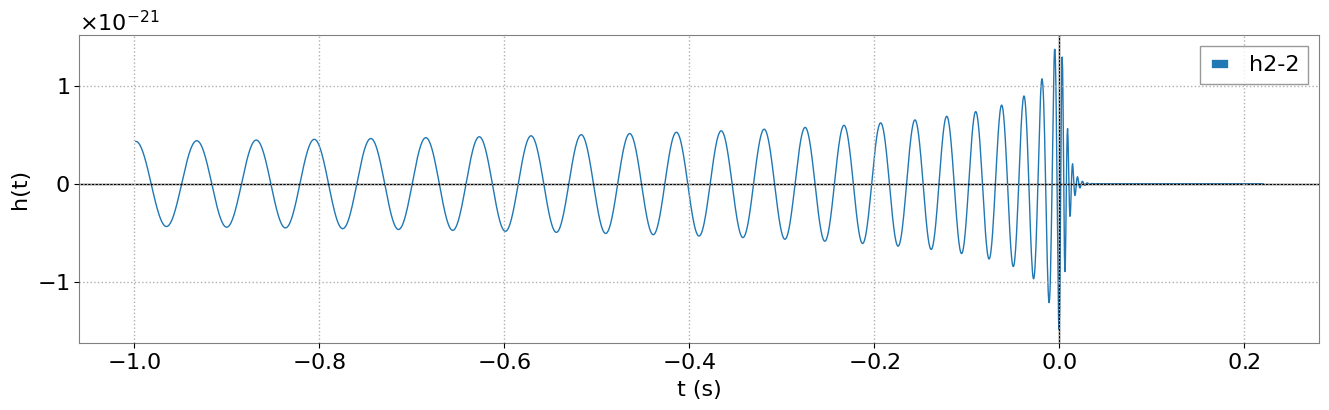

In [16]:
fig, ax = plt.subplots(1,1, figsize=[16,4])

ax.plot(hlm['t'], np.real(hlm[(2,-2)]) , label=r'h2-2')

ax.axhline(0., c='k')
ax.axvline(0., c='k')
ax.set_xlabel(r't (s)')
ax.set_ylabel(r'h(t)')
ax.legend(loc='best');

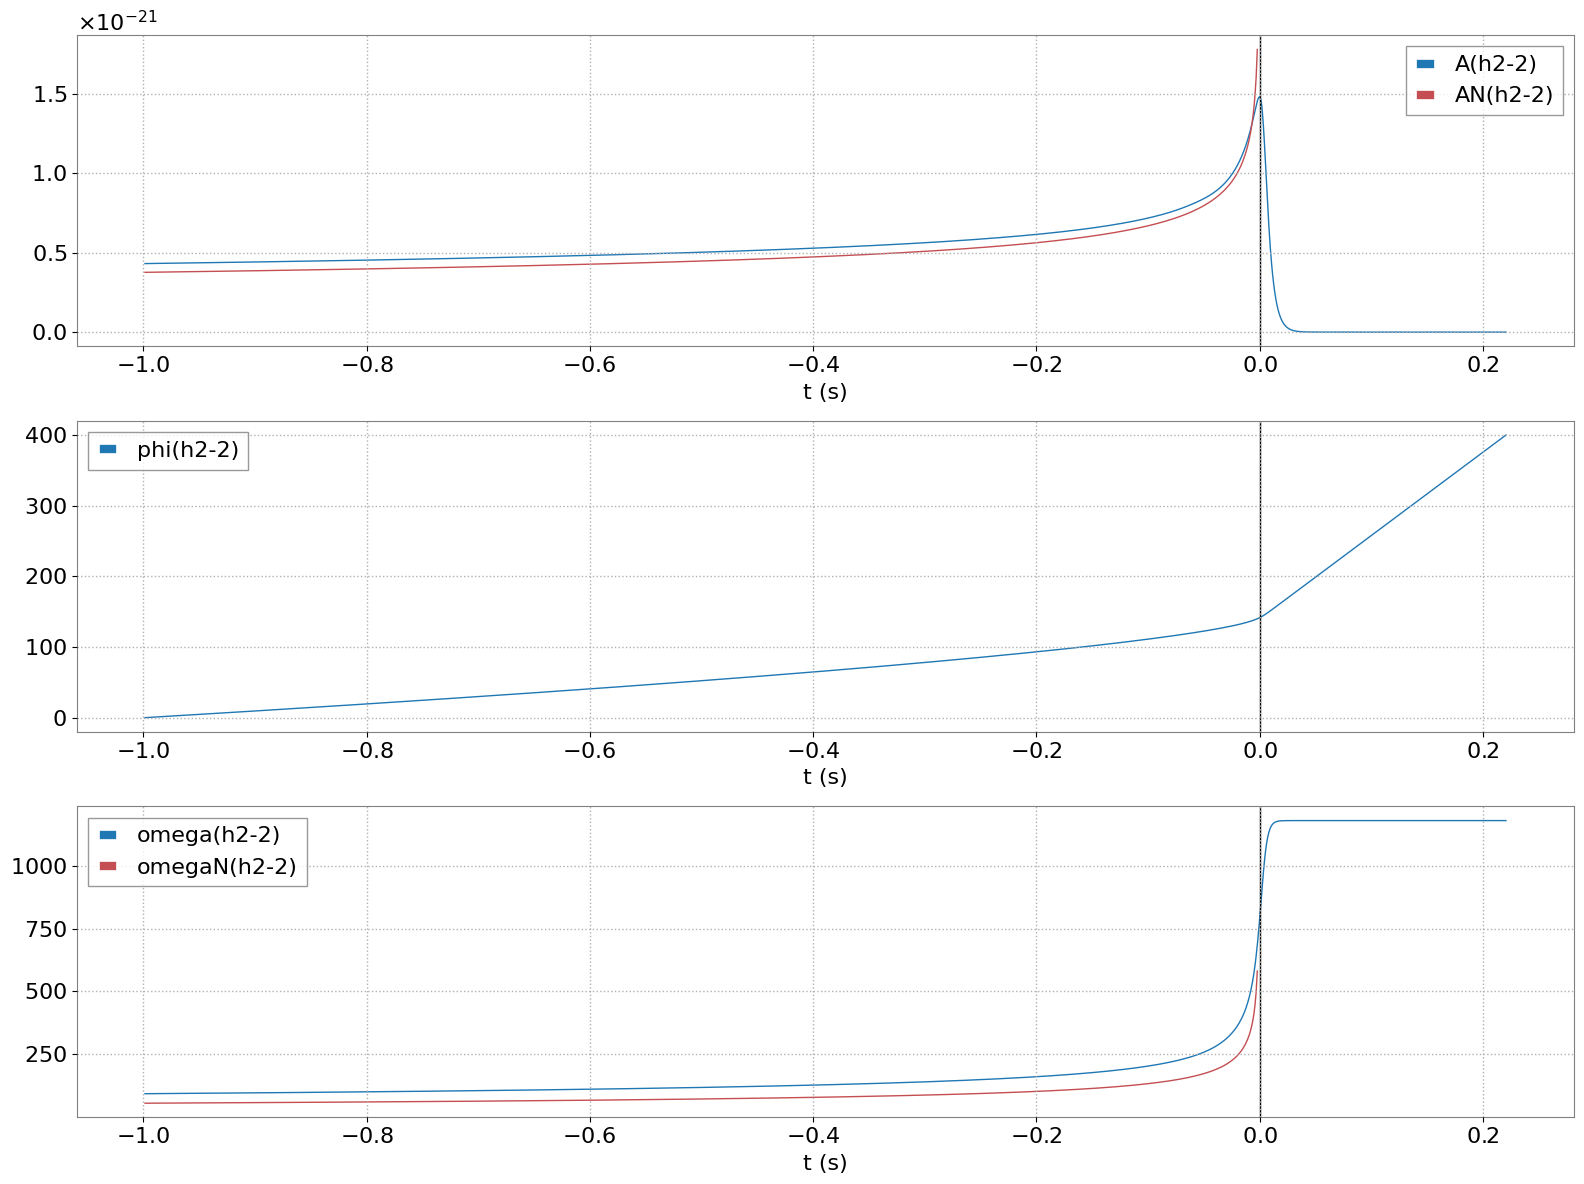

In [17]:
fig, axs = plt.subplots(3,1, figsize=[16,12])

amp = np.abs(hlm[(2,-2)])
phase = np.unwrap(np.angle(hlm[(2,-2)]))
omega = scipy.interpolate.InterpolatedUnivariateSpline(hlm['t'], phase)(hlm['t'], 1)

axs[0].plot(hlm['t'], amp, label=r'A(h2-2)')
axs[1].plot(hlm['t'], phase, label=r'phi(h2-2)')
axs[2].plot(hlm['t'], omega, label=r'omega(h2-2)')

# units
Msol_s = 4.925491025543576e-06 # GMsol/c^3
Msol_m = 1476.6250614046494 # GMsol/c^2
Mpc_m = 3.085677581491367e+22

m1, m2 = 40., 30.
Mchirp = (m1 * m2)**(3/5) / (m1 + m2)**(1/5)

tc = 0.
t_N = np.linspace(hlm['t'][0], tc - 0.002, 1000)
omega_N = (256/5 * (Mchirp*Msol_s)**(5/3) * (tc - t_N))**(-3/8)
amp_N = 2 * Mchirp*Msol_m / (1e3*Mpc_m) * (Mchirp*Msol_s*omega_N)**(2/3) * np.sqrt(16*np.pi/5)

axs[0].plot(t_N, amp_N, label=r'AN(h2-2)', c=colors[1])
axs[2].plot(t_N, omega_N, label=r'omegaN(h2-2)', c=colors[1])

for i in range(3):
    axs[i].axvline(0., c='k')
    axs[i].set_xlabel(r't (s)')
    axs[i].legend(loc='best');

fig.tight_layout()

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


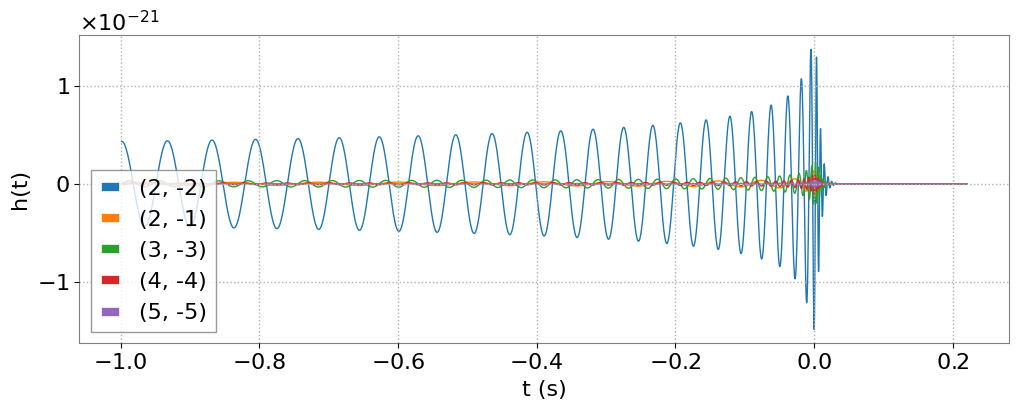

In [18]:
modes_plt = [(2,-2), (2,-1), (3,-3), (4,-4), (5,-5)]

fig, ax = plt.subplots(1,1, figsize=[12,4])

for lm in modes_plt:
    ax.plot(hlm['t'], hlm[lm], label=r''+str(lm))

ax.set_xlabel(r't (s)')
ax.set_ylabel(r'h(t)')
ax.legend(loc='best');

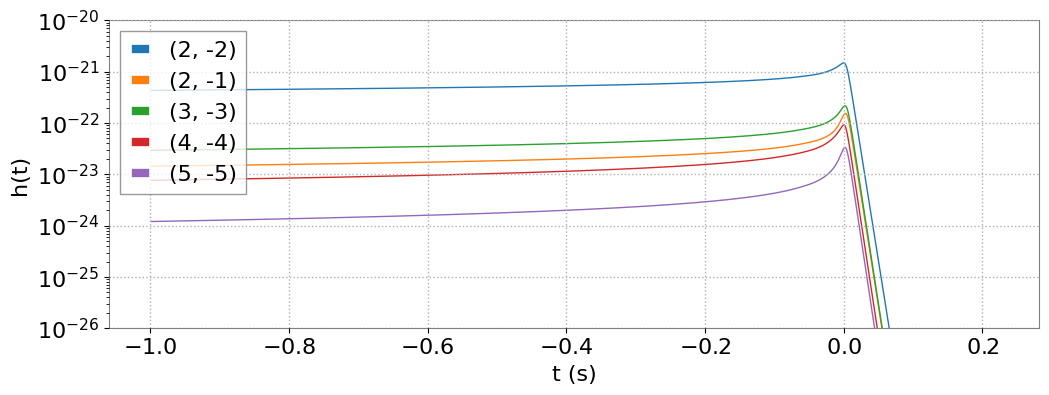

In [19]:
modes_plt = [(2,-2), (2,-1), (3,-3), (4,-4), (5,-5)]

fig, ax = plt.subplots(1,1, figsize=[12,4])

for lm in modes_plt:
    ax.plot(hlm['t'], np.abs(hlm[lm]) , label=r''+str(lm))

ax.set_yscale('log')
ax.set_ylim(1e-26, 1e-20)
ax.set_xlabel(r't (s)')
ax.set_ylabel(r'h(t)')
ax.legend(loc='upper left');

## Fourier-domain signals

In [20]:
hlm = gwsignal_GenerateFDModes(40., 30., [0., 0., 0.], [0., 0., 0.], f_min=15., f_max=1024., f_ref=15.)

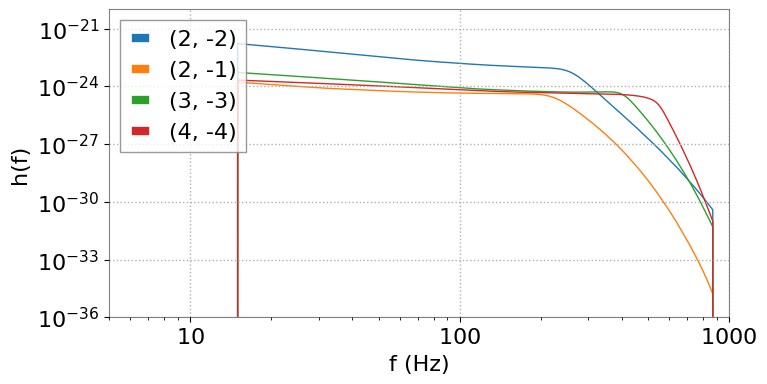

In [21]:
modes_plt = [(2,-2), (2,-1), (3,-3), (4,-4)]

fig, ax = plt.subplots(1,1, figsize=[8,4])

for lm in modes_plt:
    ax.loglog(hlm['f'], np.abs(hlm[lm]) , label=r''+str(lm))

ax.set_yscale('log')
ax.set_xlim(5., 1e3)
ax.set_ylim(1e-36, 1e-20)
ax.set_xlabel(r'f (Hz)')
ax.set_ylabel(r'h(f)')
ax.legend(loc='upper left');

## Qualitative trends

### Total mass

Plot waveforms for a set of total massses $M=m_1+m_2$ (detector-frame, redshifted masses)

In [22]:
q = 2.
Mvals = [3., 5., 10., 20., 30., 40., 80., 120.]

t, hp, hc = gwsignal_GenerateTDhphc(60., 15., [0., 0., 0.], [0., 0., 0.], f_min=15., f_ref=15., inclination=np.pi/3)

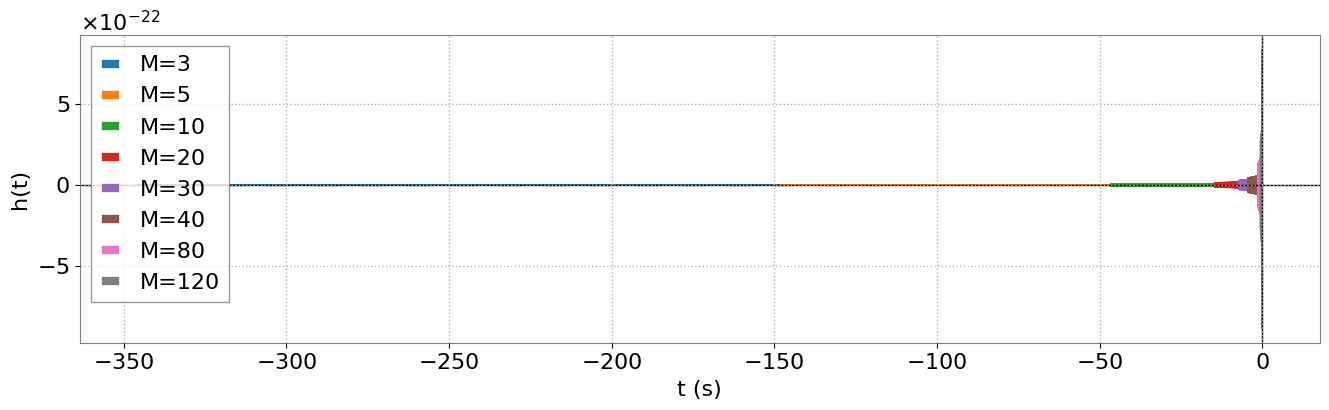

In [23]:
fig, ax = plt.subplots(1,1, figsize=[16,4])

q = 2.
Mvals = [3., 5., 10., 20., 30., 40., 80., 120.]
for M in Mvals:
    m1 = M * q / (1+q)
    m2 = M * 1 / (1+q)
    t, hp, hc = gwsignal_GenerateTDhphc(m1, m2, [0., 0., 0.], [0., 0., 0.], f_min=15., f_ref=15., inclination=np.pi/3)
    ax.plot(t, hp, label=r'M=' + str(int(M)))

ax.axhline(0., c='k')
ax.axvline(0., c='k')
ax.set_xlabel(r't (s)')
ax.set_ylabel(r'h(t)')
ax.legend(loc='best');

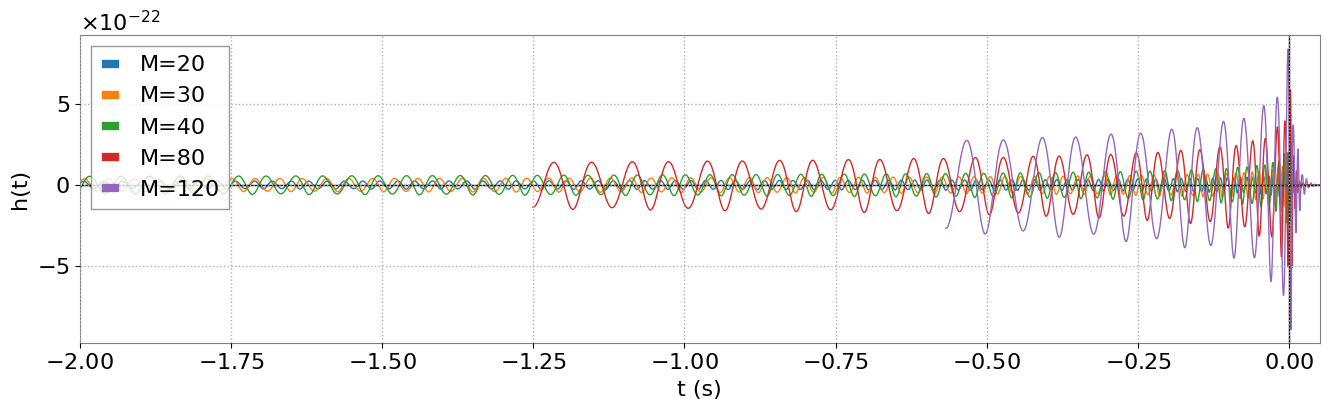

In [26]:
fig, ax = plt.subplots(1,1, figsize=[16,4])

q = 2.
Mvals = [20., 30., 40., 80., 120.]
for M in Mvals:
    m1 = M * q / (1+q)
    m2 = M * 1 / (1+q)
    t, hp, hc = gwsignal_GenerateTDhphc(m1, m2, [0., 0., 0.], [0., 0., 0.], f_min=15., f_ref=15., inclination=np.pi/3)
    ax.plot(t, hp, label=r'M=' + str(int(M)))

ax.set_xlim(-2, 0.05)
ax.axhline(0., c='k')
ax.axvline(0., c='k')
ax.set_xlabel(r't (s)')
ax.set_ylabel(r'h(t)')
ax.legend(loc='best');

Universality of waveforms for BBHs: GR is scale-free, and the only scale of both time and lengths is the total mass of the BBH $M$. Thus, in geometric units $G=c=1$, whe can work with rescaled quantities $t/M$, $M f$, and have geometric waveforms in $R h/M$. These geometric-units waveforms are what waveform modellers work with. Note that the extra physics of BNS break this scale invariance.

Check this invariance by computing two geometric waveforms for different masses (we also adjust $Mf_{\rm{nyq}}$ to be the same, to avoid differences due to sampling).

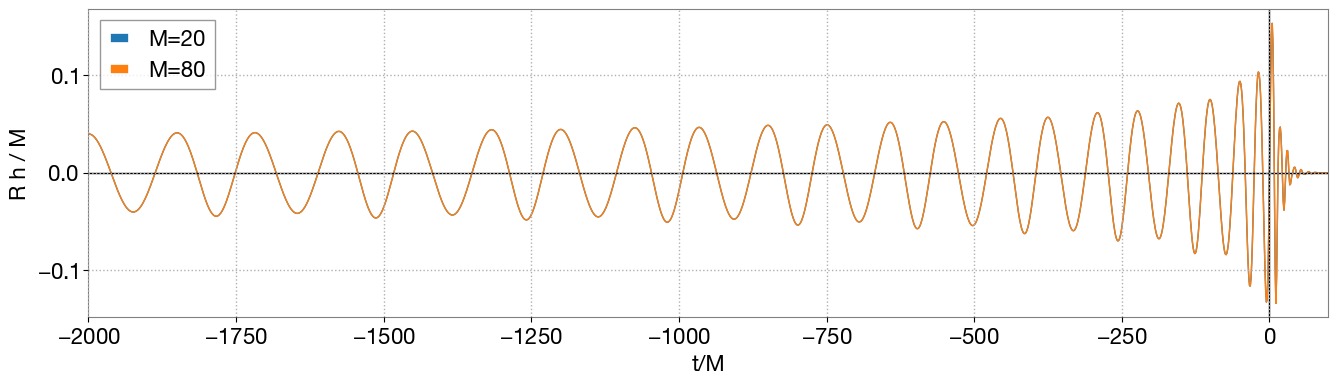

In [ ]:
fig, ax = plt.subplots(1,1, figsize=[16,4])

# units
Msol_s = 4.925491025543576e-06 # GMsol/c^3
Msol_m = 1476.6250614046494 # GMsol/c^2
Mpc_m = 3.085677581491367e+22

q = 2.
Mvals = [20., 80.]
Mref = 80.
Mref_s = Mref * Msol_s
Mfmin = 15. * Mref_s
Mf_nyquist = 1024. * Mref_s
distance = 1e3
for M in Mvals:
    m1 = M * q / (1+q)
    m2 = M * 1 / (1+q)
    M_m = M * Msol_m
    M_s = M * Msol_s
    t, hp, hc = gwsignal_GenerateTDhphc(m1, m2, [0., 0., 0.], [0., 0., 0.], f_min=Mfmin / M_s, f_ref=Mfmin / M_s, inclination=np.pi/3, f_nyquist=Mf_nyquist / M_s)
    ax.plot(t / M_s, hp * distance * Mpc_m / M_m, label=r'M=' + str(int(M)))

ax.set_xlim(-2000, 100)
ax.axhline(0., c='k')
ax.axvline(0., c='k')
ax.set_xlabel(r't/M')
ax.set_ylabel(r'R h / M')
ax.legend(loc='best');

### Inclination

Check the influence of inclination for a waveform $h_+$, $h_\times$ with higher modes included.

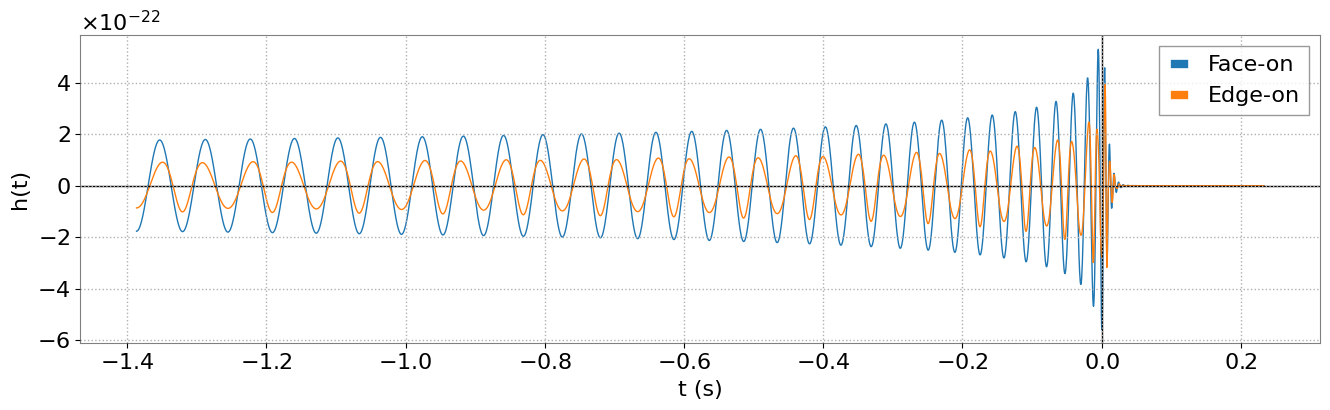

In [27]:
fig, ax = plt.subplots(1,1, figsize=[16,4])

t, hp, hc = gwsignal_GenerateTDhphc(80., 15., [0., 0., 0.], [0., 0., 0.], f_min=15., f_ref=15., inclination=0)
ax.plot(t, hp , label=r'Face-on')
t, hp, hc = gwsignal_GenerateTDhphc(80., 15., [0., 0., 0.], [0., 0., 0.], f_min=15., f_ref=15., inclination=np.pi/2)
ax.plot(t, hp , label=r'Edge-on')

ax.axhline(0., c='k')
ax.axvline(0., c='k')
ax.set_xlabel(r't (s)')
ax.set_ylabel(r'h(t)')
ax.legend(loc='best');

### Spin precession

When spins are misaligned, they can induce a precession of the orbital plane. In a moving frame (the precessing frame) following the plane of the orbits, the waveform retains (approximately) its harmonics structure; but for a fixed distant observer, modes appear to be modulated as the orbits precesses.

This is very well illustrated in the following videos by Vijay Varma:
[Binary Black Hole Explorer](https://vijayvarma392.github.io/binaryBHexp/)

Plot and compare waveforms from a precessing and non-precessing systems.

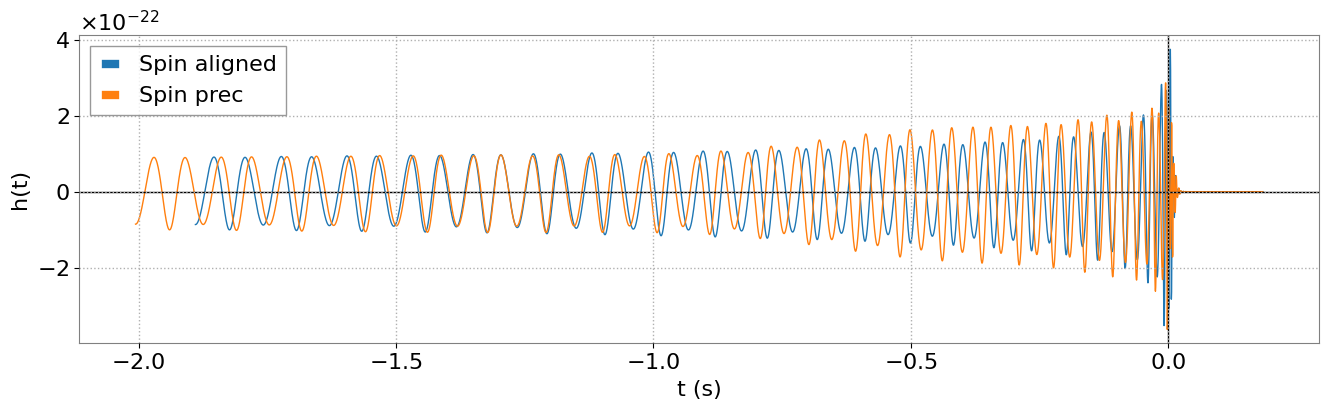

In [28]:
fig, ax = plt.subplots(1,1, figsize=[16,4])

t, hp, hc = gwsignal_GenerateTDhphc(60., 15., [0., 0., 0.], [0., 0., 0.], f_min=15., f_ref=15., inclination=np.pi/3)
ax.plot(t, hp , label=r'Spin aligned')
t, hp, hc = gwsignal_GenerateTDhphc(60., 15., [0.2, 0.8, 0.], [-0.7, 0.5, 0.], f_min=15., f_ref=15., inclination=np.pi/3)
ax.plot(t, hp , label=r'Spin prec')

ax.axhline(0., c='k')
ax.axvline(0., c='k')
ax.set_xlabel(r't (s)')
ax.set_ylabel(r'h(t)')
ax.legend(loc='best');

## FFT/IFFT and conditioning

The Discrete Fourier Transform (DFT) is implemented through the FFT algorithm as a mathematical operation, not a 'physical' Fourier tranform. For instance, `np.fft.fft` implements:
$$ \tilde{{F}}_{k} = \sum_{j=0}^{N-1} \omega^{-jk} {F}_{j} \,, \quad  {F}_{j} = \frac{1}{N}\sum_{k=0}^{N-1} \omega^{jk} \tilde{{F}}_{k} \,, \quad \omega = e^{2 i \pi / N} $$

While we would like to implement the DFT as follows, with $\Delta t \Delta f = 1/N$ and $\Delta f = 1/T$, the total duration:
$$\tilde{{F}}_{k} = \Delta t \sum_{j=0}^{N-1} \omega^{-jk} {F}_{j} \,, \quad  {F}_{j} = \Delta f \sum_{k=0}^{N-1} \omega^{jk} \tilde{{F}}_{k} \,, \quad \omega = e^{2 i \pi / N} $$
and we want to keep track of the time variable, as the DFT takes only a 1-dimensional vector as input.

It is important to ensure the Nyquist criterion: we have to choose a sampling frequency $f_s = 1/\Delta t$ such that
$$ \tilde{F}(f) \simeq 0 \quad \text{for} \quad f > f_{\rm nyq} = f_s / 2$$

The output of the DFT (and `np.fft.fft` in particular) gives the negative frequencies in the second half of the vector, $\tilde{F}_k$ for $k=N/2+1, \dots,N-1$. For a real signal, `np.fft.rfft` does the selection automatically.

In [29]:
hlm = gwsignal_GenerateTDModes(40., 30., [0., 0., 0.], [0., 0., 0.], f_min=15., f_ref=15.)
t, hp, hc = gwsignal_GenerateTDhphc(40., 30., [0., 0., 0.], [0., 0., 0.], f_min=15., f_ref=15.)

In [30]:
fft_h2m2_test = np.fft.fft(hlm[(2,-2)])
fft_hp_test = np.fft.fft(hp)

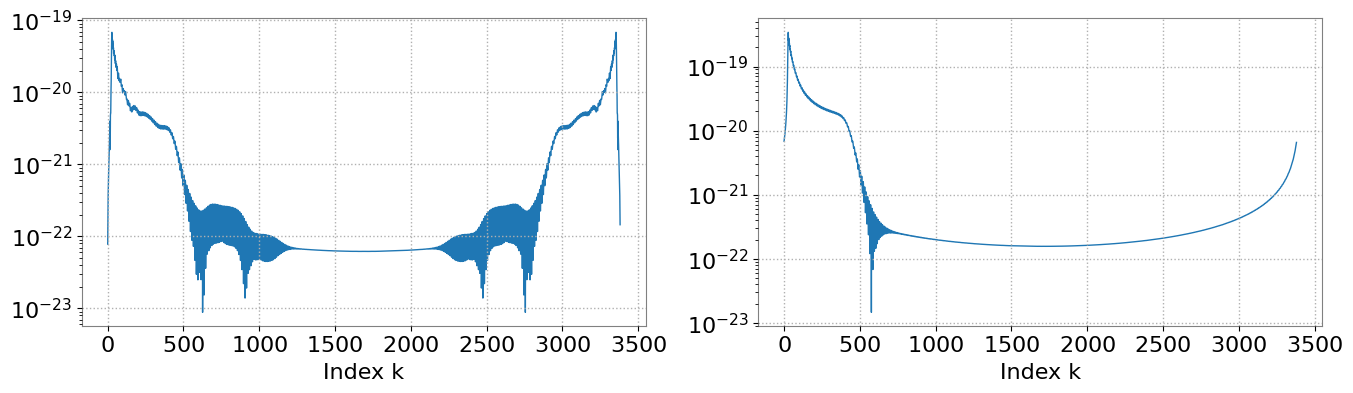

In [31]:
fig, axs = plt.subplots(1,2, figsize=[16,4])

axs[0].plot(np.abs(fft_hp_test), label=r'FFT(hplus)')
axs[1].plot(np.abs(fft_h2m2_test), label=r'FFT(h2-2)')

# ax.set_xlim(2., 800.)
# axs[1].set_xscale('log')
for i in range(2):
    axs[i].set_yscale('log')
    axs[i].set_xlabel('Index k')

The raw FFT displays the Gibbs phenomenon: sharp edges lead to spectral leakage, visible here as oscillatory features in the signal's amplitude.

Text(0.5, 0, 'Index k')

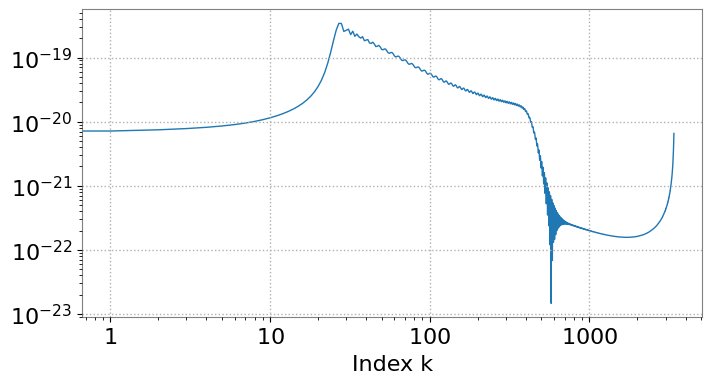

In [32]:
fig, ax = plt.subplots(1,1, figsize=[8,4])

ax.plot(np.abs(fft_h2m2_test), label=r'FFT(h2-2)')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Index k')

We will apply a smooth window to the data, tapering the edges.
Syntax: `window_planck(t, tstart, tend, deltat_start, deltat_end)` is 0 outside of `[tstart, tend]` and goes from 0 to 1 on `[tstart, tstart + deltat_start]`, and back from 1 to 0 on `[tend - deltat_end, tend]`

Text(0.5, 0, 't (s)')

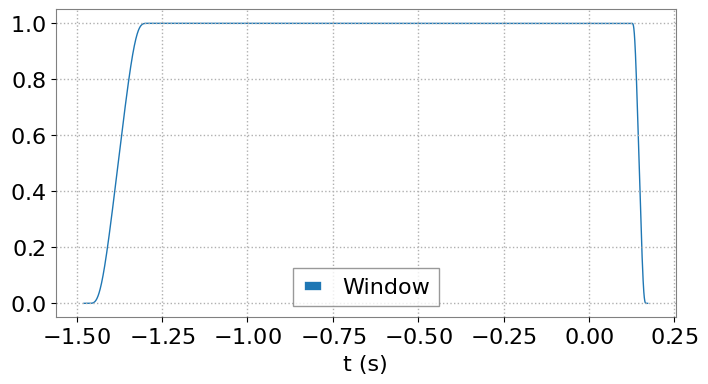

In [33]:
w = window_planck(hlm['t'], hlm['t'][0], hlm['t'][-1], 0.2, 0.05)

fig, ax = plt.subplots(1,1, figsize=[8,4])
ax.plot(hlm['t'], w, label=r'Window')
ax.legend()
ax.set_xlabel('t (s)')

In [34]:
w = window_planck(hlm['t'], hlm['t'][0], hlm['t'][-1], 0.2, 0.05)

t_pad, h2m2_pad = zeropad(hlm['t'], hlm[(2,-2)])
t_pad, h2m2_wpad = zeropad(hlm['t'], w * hlm[(2,-2)])
f, h2m2_fd = fft_positivef(t_pad, h2m2_pad)
f, h2m2w_fd = fft_positivef(t_pad, h2m2_wpad)

In [35]:
h2m2_wpad.shape, hlm[(2,-2)].shape

((4096,), (3381,))

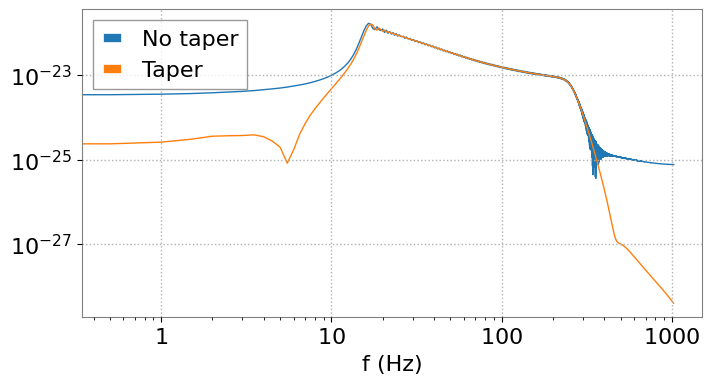

In [36]:
fig, ax = plt.subplots(1,1, figsize=[8,4])

ax.plot(f, np.abs(h2m2_fd), label=r'No taper')
ax.plot(f, np.abs(h2m2w_fd), label=r'Taper')

# ax.set_xlim(2., 800.)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('f (Hz)')
ax.legend()

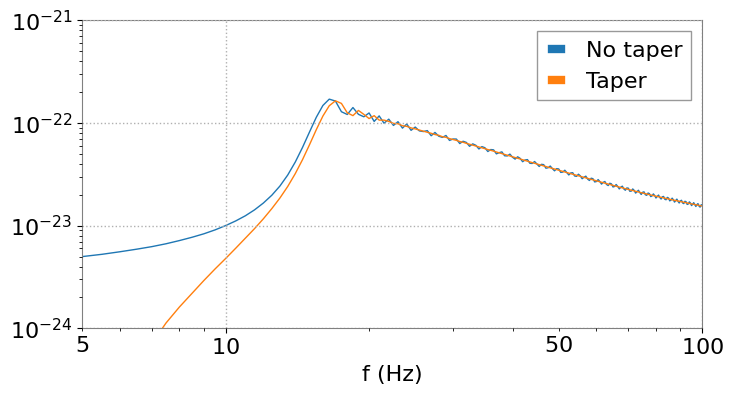

In [37]:
fig, ax = plt.subplots(1,1, figsize=[8,4])

ax.plot(f, np.abs(h2m2_fd), label=r'No taper')
ax.plot(f, np.abs(h2m2w_fd), label=r'Taper')

ax.set_xlim(5., 100.)
ax.set_ylim(1e-24, 1e-21)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('f (Hz)')
ax.legend()

Here we simply check the consistency of our IFFT function, cheking that IFFT(FFT(X))=X while keeping track of the times.

In [38]:
f, h2m2w_fd = fft_positivef(t_pad, h2m2_wpad)

In [39]:
t_ifft, h2m2w_ifft = ifft_positivef(f, h2m2w_fd, tstart=t_pad[0], real=False)

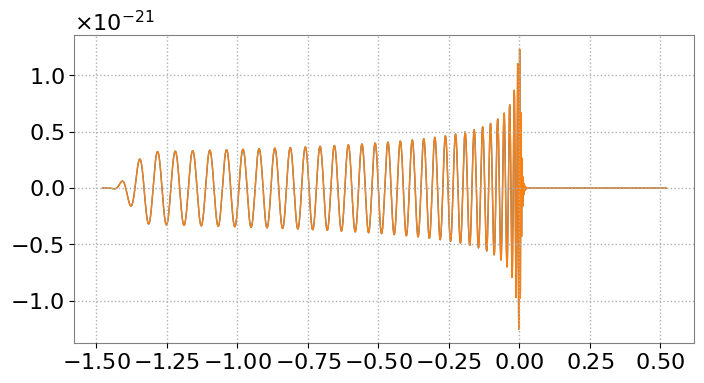

In [40]:
fig, ax = plt.subplots(1,1, figsize=[8,4])

ax.plot(t_ifft, np.real(h2m2w_ifft), label=r'')
ax.plot(t_pad, np.real(h2m2_wpad), label=r'')

# Part II: visualizing data

## Load data with gwosc and gwpy

In [41]:
from gwosc import datasets
from gwosc.datasets import find_datasets
from gwosc.datasets import event_gps

from gwpy.timeseries import TimeSeries

In [42]:
#-- List all available catalogs
print("List of available catalogs")
print(find_datasets(type="catalog"))

List of available catalogs
['GWTC', 'GWTC-1-confident', 'GWTC-1-marginal', 'GWTC-2', 'GWTC-2.1-auxiliary', 'GWTC-2.1-confident', 'GWTC-2.1-marginal', 'GWTC-3-confident', 'GWTC-3-marginal', 'IAS-O3a', 'Initial_LIGO_Virgo', 'O1_O2-Preliminary', 'O3_Discovery_Papers', 'O3_IMBH_marginal', 'O4_Discovery_Papers']


In [43]:
GWTC1_confident_events = datasets.find_datasets(type='events', catalog='GWTC-1-confident')
GWTC2_confident_events = datasets.find_datasets(type='events', catalog='GWTC-2.1-confident')
GWTC3_confident_events = datasets.find_datasets(type='events', catalog='GWTC-3-confident')

len(GWTC1_confident_events), len(GWTC2_confident_events), len(GWTC3_confident_events)

(11, 44, 35)

In [44]:
GWTC1_confident_events

['GW150914-v3',
 'GW151012-v3',
 'GW151226-v2',
 'GW170104-v2',
 'GW170608-v3',
 'GW170729-v1',
 'GW170809-v1',
 'GW170814-v3',
 'GW170817-v3',
 'GW170818-v1',
 'GW170823-v1']

### GW150914

In [45]:
t_gps = event_gps('GW150914')
print(t_gps)

1126259462.4


In [ ]:
H1_data = TimeSeries.read('./data/GW150914/H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5', format="hdf5.gwosc")
L1_data = TimeSeries.read('./data/GW150914/L-L1_GWOSC_4KHZ_R1-1126259447-32.hdf5', format="hdf5.gwosc")

In [46]:
segment = (int(t_gps) - 16, int(t_gps) + 16)
H1_data = TimeSeries.fetch_open_data('H1', *segment, verbose=True, cache=True)
L1_data = TimeSeries.fetch_open_data('L1', *segment, verbose=True, cache=True)

Fetched 1 URLs from gwosc.org for [1126259446 .. 1126259478))
Reading data... [Done]
Fetched 1 URLs from gwosc.org for [1126259446 .. 1126259478))
Reading data... [Done]


## Strain data

The data we loaded is in the form of a `gwpy` `TimeSeries` object. These objects have useful structure, including methods for conditioning/FFT, bu here we are going to convert them to raw data in the form of `numpy` arrays.

In [47]:
H1_data?

In [48]:
times = np.asarray(H1_data.times).copy()
# New origin of times: middle of our data interval
t_center = times[len(times)//2]
times -= t_center
tevent = t_gps - t_center
strain_H1 = np.asarray(H1_data).copy()
strain_L1 = np.asarray(L1_data).copy() + 1e-18 # Strain is shifted by a constant, unknown why

dt = H1_data.dt.value
fs = 1./dt
dt, fs, len(times)

(np.float64(0.000244140625), np.float64(4096.0), 131072)

Here we simply plot our raw strain data for both instruments H1 and L1.

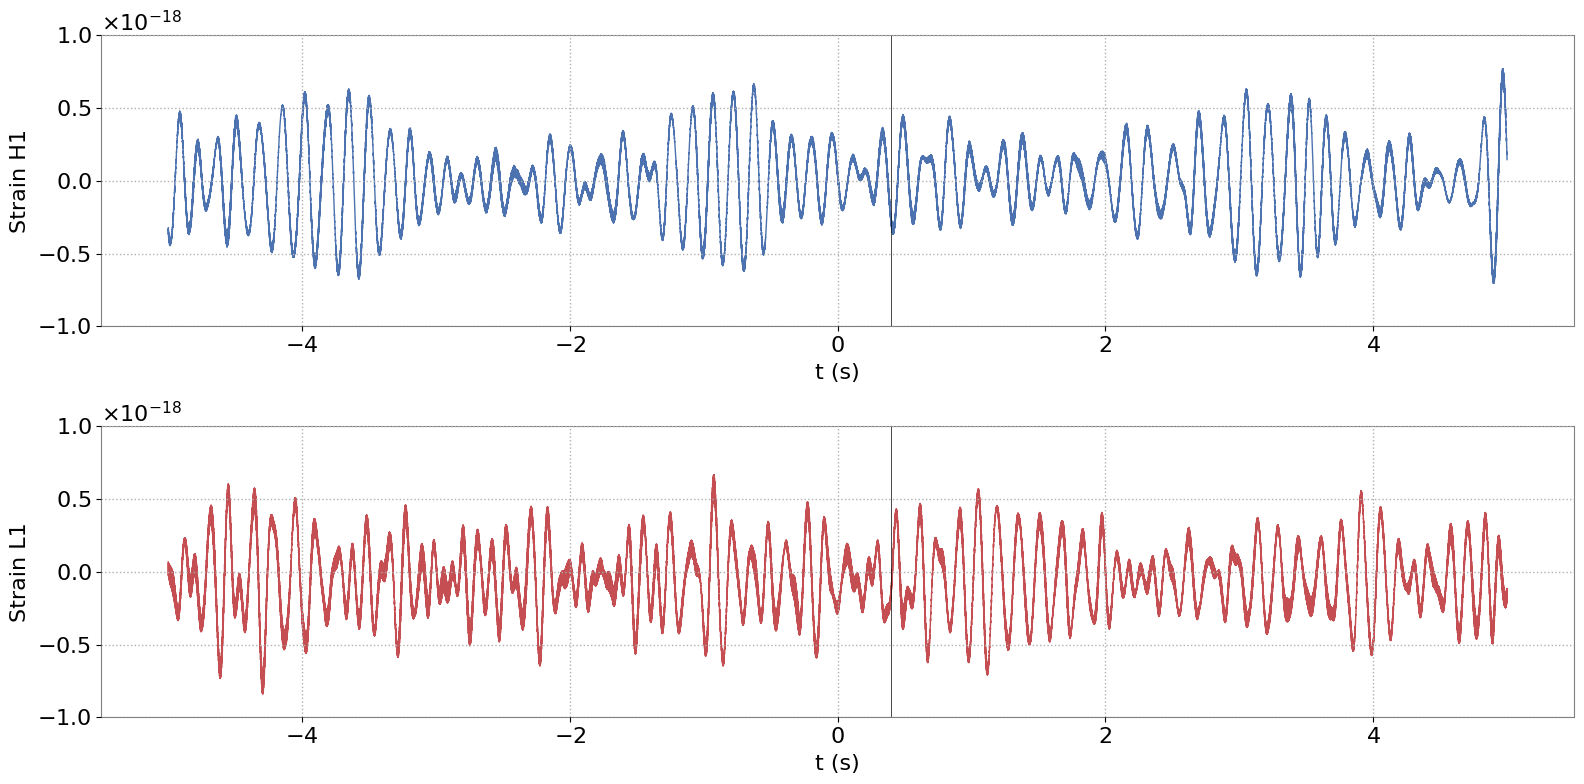

In [49]:
deltat = 5
mask = (-deltat <= times) & (times <= deltat)
ylim = [-1e-18, 1e-18]

fig, axs = plt.subplots(2,1, figsize=[16,8])
axs[0].plot(times[mask], strain_H1[mask], c=colors[0])
axs[1].plot(times[mask], strain_L1[mask], c=colors[1])

axs[0].set_ylabel(r'Strain H1')
axs[1].set_ylabel(r'Strain L1')
for i in range(2):
    axs[i].set_ylim(ylim)
    axs[i].set_xlabel(r't (s)')
    axs[i].axvline(tevent, c='k', lw=0.5)

fig.tight_layout()

## Evaluate PSD

We recall that one definition for the Power Spectral Density (PSD) of stationary noise $S_n(f)$ is (from a data stretch of length $T$)
$$ S_{n}(f) = \lim_{T \rightarrow +\infty} \frac{2}{T} \left| \tilde{n}_{T}(f) \right|^{2}$$
meaning that the PSD measures the spectral shape of the noise time series. Another useful definition is
$$ \frac{1}{2} S_{n}(f) = \int d\tau \, e^{-2 i \pi f \tau} C_n(\tau)$$
where $C_{n}(\tau)$ is the noise autocorrelation function
$$ C_{n}(\tau) = \langle n(t) n(t+\tau)\rangle$$

The stationarity is what gives use the following crucial property: the FD noise in different bins is independent, according to
$$\langle\tilde{n}(f) \tilde{n}^*(f')\rangle = \frac{1}{2} S_n(f) \delta(f - f')$$

From the first definition, we see that we can estimate the PSD by statistical averaging over data segments. This is the basis for the Welch method, where segments are windowed and overlaped, their spectrum is computed and an average (of median) of their spectra is taken. The choice of the length of the segment leads to a tradeoff: short segments mean a better statistical average, but a worse frequency resolution $\Delta f = 1/T_{\rm segment}$. Ideally, we can estimate the PSD from a stretch of data much longer than the signal but much shorter than the timescale where the noise becomes non-stationary. Real-life detector characterization is much more involved than what we do here !

In [ ]:
scipy.signal.welch?

Signature:
scipy.signal.welch(
    x,
    fs=1.0,
    window='hann',
    nperseg=None,
    noverlap=None,
    nfft=None,
    detrend='constant',
    return_onesided=True,
    scaling='density',
    axis=-1,
    average='mean',
)
Docstring:
Estimate power spectral density using Welch's method.

Welch's method [1]_ computes an estimate of the power spectral
density by dividing the data into overlapping segments, computing a
modified periodogram for each segment and averaging the
periodograms.

Parameters
----------
x : array_like
    Time series of measurement values
fs : float, optional
    Sampling frequency of the `x` time series. Defaults to 1.0.
window : str or tuple or array_like, optional
    Desired window to use. If `window` is a string or tuple, it is
    passed to `get_window` to generate the window values, which are
    DFT-even by default. See `get_window` for a list of windows and
    required parameters. If `window` is array_like it will be used
    directly as the window 

In [50]:
freqs_psd, psd_H1 = scipy.signal.welch(strain_H1, fs,  window='hann', nperseg=16384, scaling='density')
freqs_psd, psd_L1 = scipy.signal.welch(strain_L1, fs,  window='hann', nperseg=16384, scaling='density')

# We will use interpolations of the ASDs computed above for whitening:
psd_H1_interp = scipy.interpolate.interp1d(freqs_psd, psd_H1)
psd_L1_interp = scipy.interpolate.interp1d(freqs_psd, psd_L1)

In [51]:
psd_H1.shape, freqs_psd[1] - freqs_psd[0]

((8193,), np.float64(0.25))

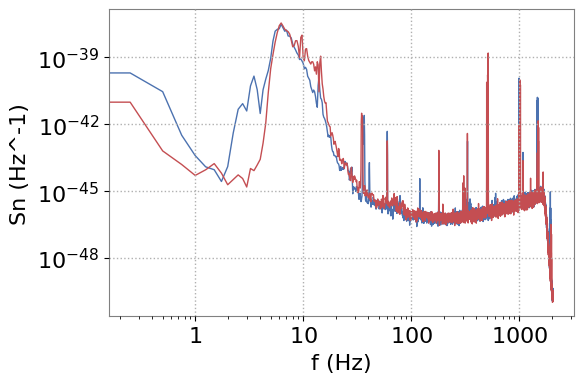

In [52]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.loglog(freqs_psd, psd_H1, c=colors[0], lw=1)
ax.loglog(freqs_psd, psd_L1, c=colors[1], lw=1)

# ax.set_xlim([5., 2048.])
ax.set_xlabel(r'f (Hz)')
ax.set_ylabel(r'Sn (Hz^-1)')

fig.tight_layout()

In [53]:
freqs_psd_lowres, psd_H1_lowres = scipy.signal.welch(strain_H1, fs,  window='hann', nperseg=2048, scaling='density')
freqs_psd_lowres, psd_L1_lowres = scipy.signal.welch(strain_L1, fs,  window='hann', nperseg=2048, scaling='density')

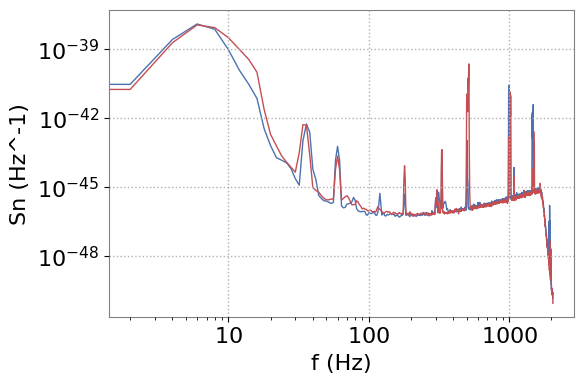

In [54]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.loglog(freqs_psd_lowres, psd_H1_lowres, c=colors[0], lw=1)
ax.loglog(freqs_psd_lowres, psd_L1_lowres, c=colors[1], lw=1)

# ax.set_xlim([5., 2048.])
ax.set_xlabel(r'f (Hz)')
ax.set_ylabel(r'Sn (Hz^-1)')

fig.tight_layout()

## Data visualization: tapering, band-passing, whitening, spectrogram

A useful representation of the data is given by the band-passing and whitening procedure.

Band-passing amounts to multiplying the data by a window $w(f)$ selecting the frequency range of interest, going smoothly to 0 on either side. This will have the effect of eliminating a lot of irrelevant power in the noise. Recall that we have independence in Fourier bins for stationary noise, allowing us to ignore low and high frequencies.

Recall that we the inner product intervening in the matched filter statistic and the likelihood is
$$ ( a | b ) = 4 \mathrm{Re} \int_{0}^{+\infty} df \; \frac{\tilde{a}^{*}(f)\tilde{b}(f)}{S_n(f)}$$

or in discrete form (up to small change at the edges $j=0,N/2$)
$$ ( a | b ) = 4 \Delta f \mathrm{Re} \sum_{j} \frac{\tilde{a}_{j}^{*} \tilde{b}_{j}}{S_{n}(j \Delta f)} $$

This motivates introducing the whitened, band-passed signals
$$ \tilde{a}_{\rm wbp} (f) = w(f) \times \sqrt{\frac{2 \Delta f}{S_n(f)}} \tilde{a}(f)$$

In those new variables, for real signals $a,b \in \mathbb{R}$
$$ ( a | b ) = \int_{-\infty}^{+\infty} df \; \tilde{a}_{\rm wbp}^{*}(f) \tilde{b}_{\rm wbp}(f) = \int_{-\infty}^{+\infty} dt \; a_{\rm wbp}(t) b_{\rm wbp}(t)$$
(assuming $w(f)$ only affects regions where the noise was killing the integrand anyway). We have used the Plancherel theorem at then to translate in the time domain. Thus, in whitened-band-passed variables, ``what you see is what you get'': contributions to the SNR can be read by eye, all times are equally important. We recover also independance that we would have between time samples of white noise.

In [56]:
# Data selected to be +-2s around the event
# _d for 'data' that we are going to actually use

# n = 2**np.round(np.log2(4. / dt))
n = len(times)
# mask_d = ( -n//2*dt <= time) & (time < n//2*dt)
mask_d = np.ones(n, dtype=bool)
times_d = times[mask_d]
strain_H1_d = strain_H1[mask_d]
strain_L1_d = strain_L1[mask_d]

n, n*dt, len(times_d), [times_d[0], times_d[-1]]

(131072,
 np.float64(32.0),
 131072,
 [np.float64(-16.0), np.float64(15.999755859375)])

In [64]:
# Tapering data at both ends
# w = pytools.window_planck_vec(time_d, time_d[0], time_d[-1], 0.5, 0.5)
w = window_planck(times_d, times_d[0], times_d[-1], 2., 2.)
strain_H1_tap = w * strain_H1_d
strain_L1_tap = w * strain_L1_d

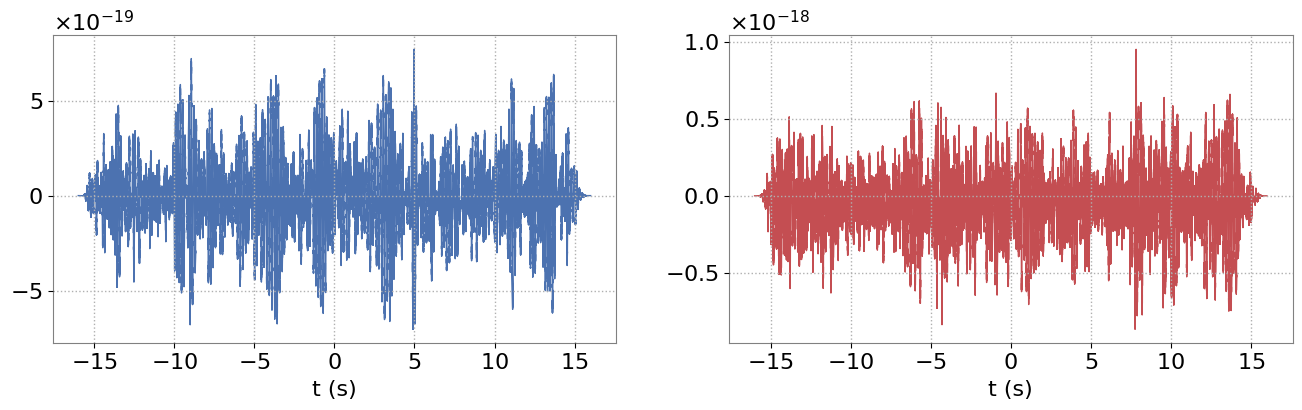

In [65]:
fig, axs = plt.subplots(1,2, figsize=[16,4])
axs[0].plot(times_d, strain_H1_tap, c=colors[0])
axs[1].plot(times_d, strain_L1_tap, c=colors[1])

for i in range(2):
    axs[i].set_xlabel(r't (s)')

In [66]:
# Data FD
f_d, strain_H1_fd = fft_positivef(times_d, strain_H1_tap)
f_d, strain_L1_fd = fft_positivef(times_d, strain_L1_tap)

df = f_d[1] - f_d[0]
df

np.float64(0.03125)

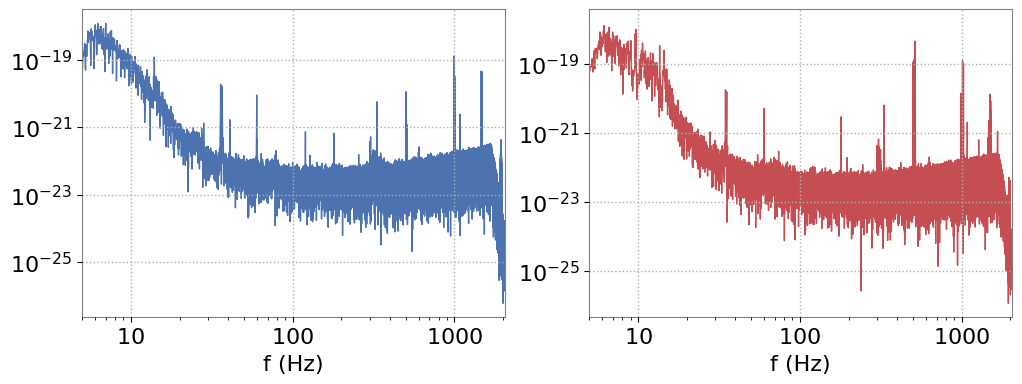

In [68]:
fig, axs = plt.subplots(1,2, figsize=[12,4])
axs[0].loglog(f_d, np.abs(strain_H1_fd), c=colors[0])
axs[1].loglog(f_d, np.abs(strain_L1_fd), c=colors[1])

for i in range(2):
    axs[i].set_xlim([5., 2048.])

for i in range(2):
    axs[i].set_xlabel(r'f (Hz)')

In [69]:
# Data band-passed (no whitening)

w_bp = window_planck(f_d, 10., 512., 10., 64.)

strain_H1_fd_bp = w_bp * strain_H1_fd
strain_L1_fd_bp = w_bp * strain_L1_fd

_, strain_H1_td_bp = ifft_positivef(f_d, strain_H1_fd_bp, real=True, tstart=times_d[0])
_, strain_L1_td_bp = ifft_positivef(f_d, strain_L1_fd_bp, real=True, tstart=times_d[0])

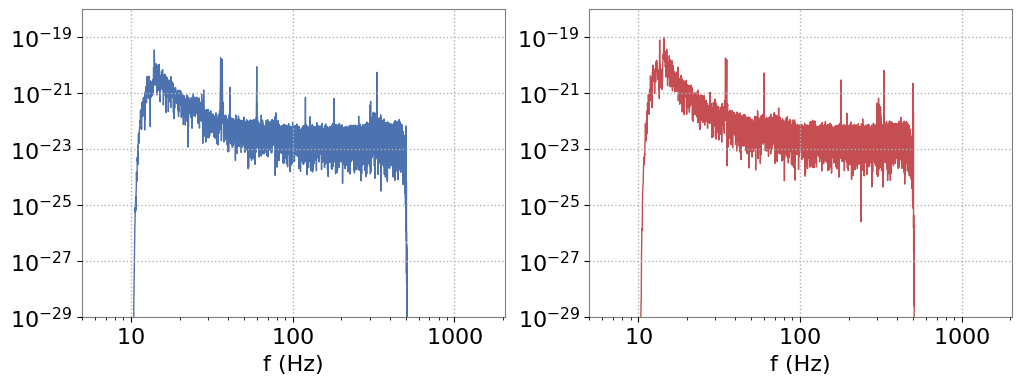

In [70]:
fig, axs = plt.subplots(1,2, figsize=[12,4])
axs[0].loglog(f_d, np.abs(strain_H1_fd_bp), c=colors[0])
axs[1].loglog(f_d, np.abs(strain_L1_fd_bp), c=colors[1])

for i in range(2):
    axs[i].set_xlim([5., 2048.])
    axs[i].set_ylim([1e-29, 1e-18])

for i in range(2):
    axs[i].set_xlabel(r'f (Hz)')

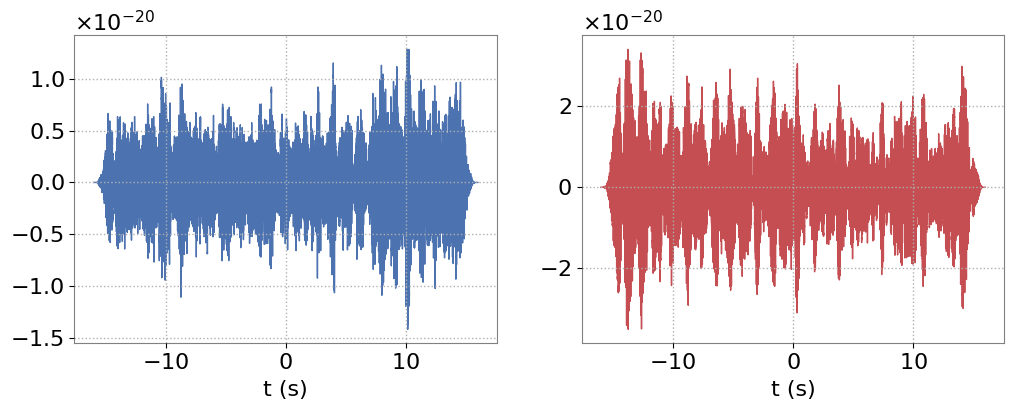

In [71]:
fig, axs = plt.subplots(1,2, figsize=[12,4])
axs[0].plot(times_d, strain_H1_td_bp, c=colors[0])
axs[1].plot(times_d, strain_L1_td_bp, c=colors[1])

for i in range(2):
    axs[i].set_xlabel(r't (s)')

In [72]:
# Data whitened after band-passing

w_bp = window_planck(f_d, 10., 512., 10., 64.)

strain_H1_fd_wbp = w_bp * np.sqrt(2*df / psd_H1_interp(f_d)) * strain_H1_fd
strain_L1_fd_wbp = w_bp * np.sqrt(2*df / psd_L1_interp(f_d)) * strain_L1_fd

_, strain_H1_td_wbp = ifft_positivef(f_d, strain_H1_fd_wbp, real=True, tstart=times_d[0])
_, strain_L1_td_wbp = ifft_positivef(f_d, strain_L1_fd_wbp, real=True, tstart=times_d[0])

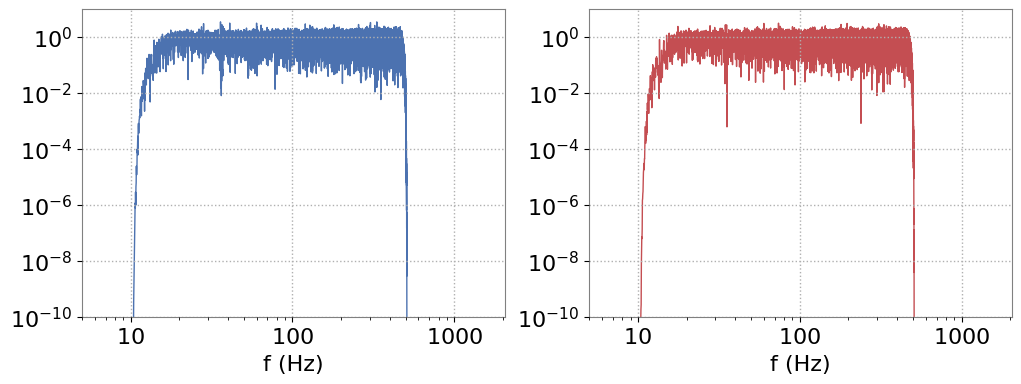

In [73]:
fig, axs = plt.subplots(1,2, figsize=[12,4])
axs[0].loglog(f_d, np.abs(strain_H1_fd_wbp), c=colors[0])
axs[1].loglog(f_d, np.abs(strain_L1_fd_wbp), c=colors[1])

for i in range(2):
    axs[i].set_xlim([5., 2048.])
    axs[i].set_ylim([1e-10, 1e1])

for i in range(2):
    axs[i].set_xlabel(r'f (Hz)')

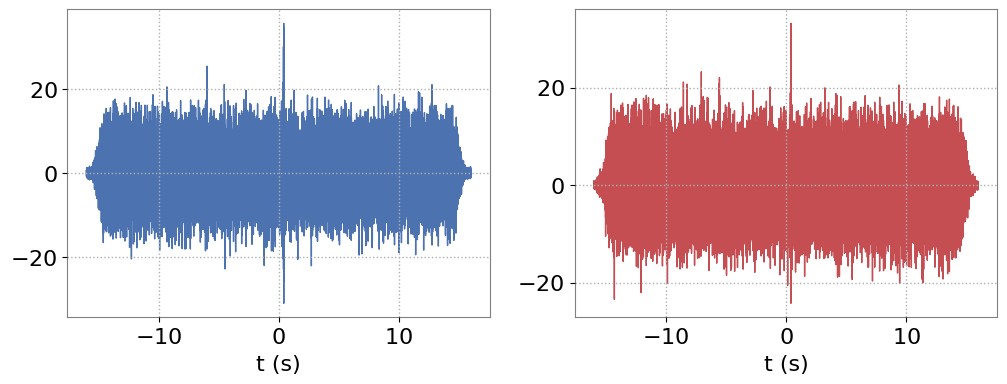

In [74]:
fig, axs = plt.subplots(1,2, figsize=[12,4])
axs[0].plot(times_d, strain_H1_td_wbp, c=colors[0])
axs[1].plot(times_d, strain_L1_td_wbp, c=colors[1])

for i in range(2):
    axs[i].set_xlabel(r't (s)')

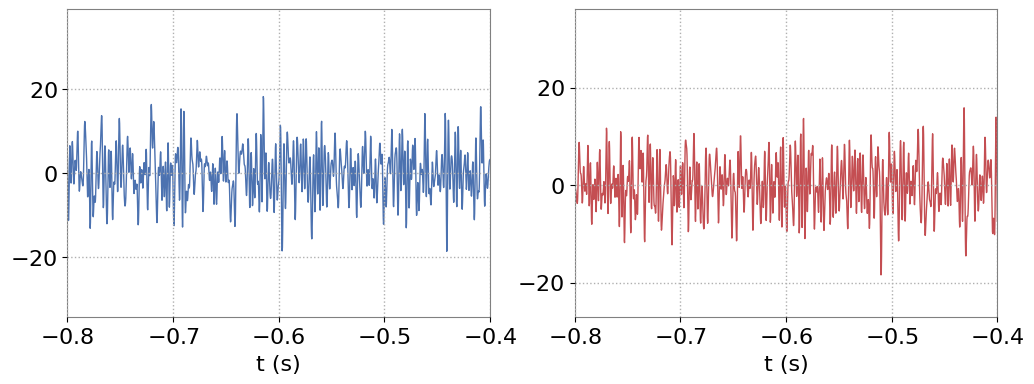

In [76]:
fig, axs = plt.subplots(1,2, figsize=[12,4])
axs[0].plot(times_d, strain_H1_td_wbp, c=colors[0])
axs[1].plot(times_d, strain_L1_td_wbp, c=colors[1])

for i in range(2):
    axs[i].set_xlim([-0.8, -0.4])

for i in range(2):
    axs[i].set_xlabel(r't (s)')

## Time-frequency visualizations: Q-transforms (pictures only !)

For Q-transforms, we refer to the tutorials 1.3 and 2.3 available at the GWOSC: [Gravitational-Wave Open Science Center (GWOSC)](https://www.gw-openscience.org).

### GW170814

The event in the three detectors H1, L1 and V1:

![Q-tranform near GW170814](https://github.com/SylvainMarsat/gwda_tutorial/blob/main/images/GW170814_H1_qtransform.png?raw=1)

![Q-tranform near GW170814](https://github.com/SylvainMarsat/gwda_tutorial/blob/main/images/GW170814_L1_qtransform.png?raw=1)

![Q-tranform near GW170814](https://github.com/SylvainMarsat/gwda_tutorial/blob/main/images/GW170814_V1_qtransform.png?raw=1)

And a glitch in the vicinity:

![Q-tranform near GW170814](https://github.com/SylvainMarsat/gwda_tutorial/blob/main/images/GW170814_H1_glitch_qtransform.png?raw=1)

![Q-tranform near GW170814](https://github.com/SylvainMarsat/gwda_tutorial/blob/main/images/GW170814_L1_glitch_qtransform.png?raw=1)

![Q-tranform near GW170814](https://github.com/SylvainMarsat/gwda_tutorial/blob/main/images/GW170814_V1_glitch_qtransform.png?raw=1)

### GW170817

H1 data for the BNS signal:

![Q-tranform near GW170817](https://github.com/SylvainMarsat/gwda_tutorial/blob/main/images/GW170817_H1_qtransform.png?raw=1)

L1 data for the BNS signal, affected by a large glitch:

![Q-tranform near GW170817](https://github.com/SylvainMarsat/gwda_tutorial/blob/main/images/GW170817_L1_qtransform.png?raw=1)

# Part III: matched filtering example with GW150914

## Data and template

The mass parameters (and distance, rescaled anyway) for the template were taken from here:

[GWOSC event page for GW150914](https://gwosc.org/eventapi/html/GWTC-1-confident/GW150914/v3/)

In [81]:
t_gps = event_gps('GW150914')
print(t_gps)

1126259462.4


In [ ]:
H1_data = TimeSeries.read('./data/GW150914/H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5', format="hdf5.gwosc")
L1_data = TimeSeries.read('./data/GW150914/L-L1_GWOSC_4KHZ_R1-1126259447-32.hdf5', format="hdf5.gwosc")

In [87]:
segment = (int(t_gps) - 16, int(t_gps) + 16)
H1_data = TimeSeries.fetch_open_data('H1', *segment, verbose=True, cache=True)
L1_data = TimeSeries.fetch_open_data('L1', *segment, verbose=True, cache=True)

Fetched 1 URLs from gwosc.org for [1126259446 .. 1126259478))
Reading data... [Done]
Fetched 1 URLs from gwosc.org for [1126259446 .. 1126259478))
Reading data... [Done]


In [88]:
# Allows to select a subest of data
# Here we use it all

# n = 2**np.round(np.log2(4. / dt))
n = len(times)
# mask_d = ( -n//2*dt <= time) & (time < n//2*dt)
mask_d = np.ones(n, dtype=bool)
times_d = times[mask_d]
strain_H1_d = strain_H1[mask_d]
strain_L1_d = strain_L1[mask_d]

n, n*dt, len(times_d), [times_d[0], times_d[-1]]

(131072,
 np.float64(32.0),
 131072,
 [np.float64(-16.0), np.float64(15.999755859375)])

In [89]:
# Generate TD h2-2 template from best-guess masses
m1 = 34.6
m2 = 30.0
dist = 470.

template_hlm = gwsignal_GenerateTDModes(m1, m2, [0., 0., 0.], [0., 0., 0.], dist=dist, f_min=6., f_ref=100., f_nyquist=2048.)

t, template = template_hlm['t'], template_hlm[(2,-2)]

/usr/local/lib/python3.11/dist-packages/lalsimulation/gwsignal/core/waveform.py:226: UserWarning: This code is currently UNREVIEWED, use with caution!
  warnings.warn("This code is currently UNREVIEWED, use with caution!")


Text(0.5, 0, 't (s)')

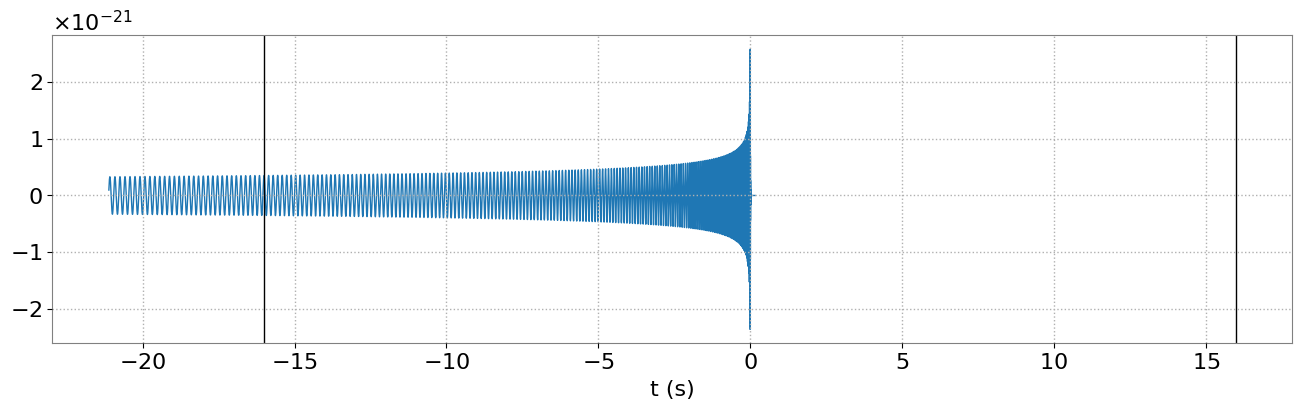

In [90]:
fig, ax = plt.subplots(1,1, figsize=[16,4])
ax.plot(t, np.real(template))
ax.axvline(times_d[0], c='k')
ax.axvline(times_d[-1], c='k')

ax.set_xlabel(r't (s)')

In [91]:
# Template FD
# Tapering template at both ends
# Extend to the size of data
# Shift in time so that t=0 for template is at tpeak

# w_template = window_planck(t, t[0], t[-1], 0.5, 0.5)

template_d = np.zeros_like(strain_H1_d, dtype=complex)
# i0_template = np.argmin(np.abs(t))
# i0_data = np.argmin(np.abs(times_d))
istart_template = np.where(times_d[0] < t)[0][0]

mask_template = (times_d[0] < t)
mask_data = (times_d < t[-1])
template_d[mask_data] = template[mask_template]

w = window_planck(times_d, -8., 8., 2., 2.)

f, template_fd = fft_positivef(times_d, w * template_d)

Text(0.5, 0, 't (s)')

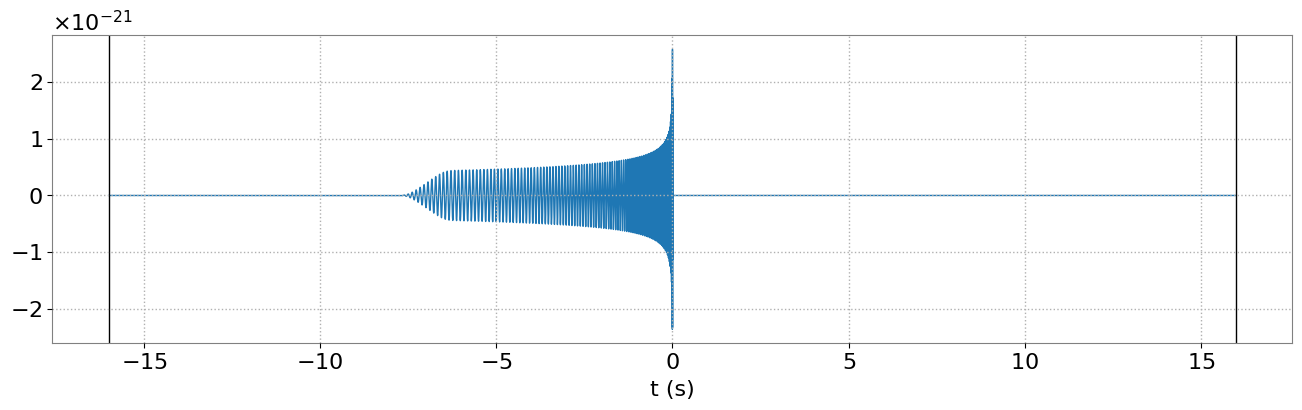

In [92]:
fig, ax = plt.subplots(1,1, figsize=[16,4])
ax.plot(times_d, np.real(w * template_d))
ax.axvline(times_d[0], c='k')
ax.axvline(times_d[-1], c='k')

ax.set_xlabel(r't (s)')

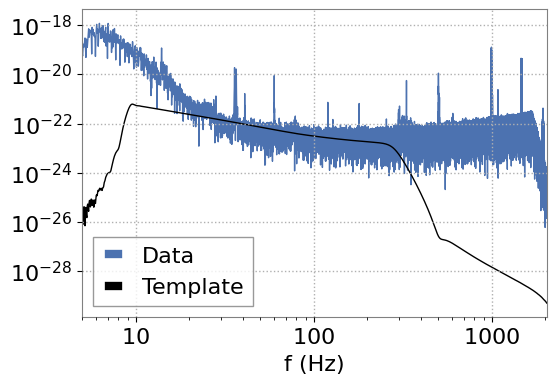

In [93]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.loglog(f_d, np.abs(strain_H1_fd), c=colors[0], label=r'Data')
ax.loglog(f_d, np.abs(template_fd), c='k', label=r'Template')

ax.set_xlim(5., 2048.)

ax.set_xlabel(r'f (Hz)')
ax.legend(loc='lower left')

## Basics of matched filtering

A simplified view on matched filtering: in stationary Gaussian noise, we wish to filter the data with a filter $W(t)$
$$\hat{s} = \int dt \, W(t) s(t)$$
$$\hat{n} = \int dt \, W(t) n(t)$$
in order to maximize the signal to noise ratio. Defining
$$ S = \langle \hat{s} \rangle \,, \quad N^{2} = \langle \hat{n}^{2} \rangle \,, \quad N = \sqrt{N^{2}}$$
the purpose will be to design $W(t)$ to maximize the SNR $S/N$. If we assume that we know exactly the true signal $h$, then the result for the matched filter is
$$ \tilde{W}(f) = \frac{2 \tilde{h}(f)}{S_{n}(f)}$$
Introducing the noise-weighted inner product
$$ ( a | b ) = 4 \mathrm{Re} \int_{0}^{+\infty} df \; \frac{\tilde{a}^{*}(f)\tilde{b}(f)}{S_n(f)}$$
the matched filter SNR statistic is
$$\hat{\rho} = \frac{\hat{s}}{N} =  \frac{(h | s)}{\sqrt{(h | h)}}$$
The optimal SNR, in the absence of noise $n=0$, is $\rho_{\rm opt} = \sqrt{(h | h)}$.

In our simplified assumptions of stationary Gaussian noise, the distribution of $\hat{\rho}$ is
$$\text{In noise: } \hat{\rho} = \frac{\hat{n}}{N} \sim \mathcal{N}(0,1)$$
$$\text{In presence of signal: } \hat{\rho} = \rho_{\rm opt} + \frac{\hat{n}}{N} \sim \mathcal{N}(\rho_{\rm opt},1)$$

Real-life searches have to differ from this very simplified view: first, here we assume that we know $h$ exactly, while in reality we have to scan the data with multiple templates covering the parameter space. Second, real noise is non-stationary and non-Gaussian, which leads to the use of modified statistics that penalize loud glitches (e.g. using a $\chi^2$ measure), and to attributing significance to a detection by estimating a background distribution from real data time slides.

## Matched filter

The observed strain $h_{\rm observed}$ depends on many extrinsic geometric parameters, while the modes $h_{\ell m}$ depend on intrinsic parameters and are scaled in amplitude by the luminosity distance as $1/d_L$: first, the spin-weighted spharical harmonics ${}_{-2}Y_{\ell m}(\iota, \varphi)$ depend on the inclination $\iota$ and the observer's azimuth in the source frame $\varphi$, which influences $h_+, h_\times$. Then, the observed strain is given (for LVK-like instruments) by
$$h_{\rm observed} = F_+ h_+ + F_\times h_\times$$
where $F_+$, $F_\times$ are the detector pattern function, that depend on the position in the sky $\mathrm{ra}, \mathrm{dec}$ and the polarization angle $\psi$. Finally, the time of arrival of the signal at each detector is different, due to the wave's propagation.

Here, with a single detector, and a single mode in the waveform, we have in fact geometric degeneracies; we will accept that there exist an effective amplitude $A(\theta,\phi,\mathrm{ra}, \mathrm{dec},\psi)$ and an effective phase $\alpha(\theta,\phi,\mathrm{ra}, \mathrm{dec},\psi)$ so that we can use the template
$$ \tilde{h}_{\rm temp}(f) = A e^{i \alpha} e^{-2 i \pi f \Delta t} \tilde{h}_{2,-2}(f)$$
for a given time shift $\Delta t$. Here this is valid for $f > 0$ only, and we use the complex $\tilde{h}_{2,-2}(f)$; however $\tilde{h}_{\rm temp}$ is the Fourier tranform of a real signal.

We will use the Wiener filter $\tilde{W}(f) = 2\tilde{h}_{\rm temp}(f) / S_n(f)$, and we want to be able to optimize the match over the time and phase degrees of freedom.

The match that we want to compute and optimize over $A$, $\alpha$ and $\Delta t$:
$$ M( A, \alpha, \Delta t) = 4 \mathrm{Re} \int_{0}^{+\infty} df \; \frac{1}{S_n(f)} \tilde{d}(f) A e^{-i \alpha} e^{+2 i \pi f \Delta t} \tilde{h}_{2,-2}^*(f)$$

Using the fact that $\tilde{h}_{\rm temp}(f)$ comes from a real signal to come back to frequencies on $[-\infty, +\infty]$, we find that we are can compute
$$ M( A, \alpha, \Delta t) = 2 \int_{-\infty}^{+\infty} df \; e^{+2 i \pi f \Delta t} \left[\frac{1}{S_n(f)} \tilde{d}(f) A e^{-i \alpha} \tilde{h}_{2,-2}^*(f) \right] = \mathrm{IFFT}\left[ \frac{1}{S_n(f)} \tilde{d}(f) A e^{-i \alpha} \tilde{h}_{2,-2}^*(f)  \right](\Delta t)$$

For the optimization of the phase, since we have a global phase $\alpha$, we can write
$$ M( A, \alpha, \Delta t) = \mathrm{Re} (e^{-i \alpha} \xi)$$
for some complex quantity $\xi$. The optimization is then simply
$$ \mathrm{max}_\alpha M( A, \alpha, \Delta t) = |\xi| \,, \quad \alpha_{\rm max} = - \mathrm{Arg}(\alpha) $$

Using the fact that $\tilde{h}_{\rm temp}(f)$ comes from a real signal to come back to frequencies on $[-\infty, +\infty]$, we find that we are can compute
$$ M( A, \alpha, \Delta t) = 2 \int_{-\infty}^{+\infty} df \; e^{+2 i \pi f \Delta t} \left[\frac{1}{S_n(f)} \tilde{d}(f) A e^{-i \alpha} \tilde{h}_{2,-2}^*(f) \right] = \mathrm{IFFT}\left[ \frac{1}{S_n(f)} \tilde{d}(f) A e^{-i \alpha} \tilde{h}_{2,-2}^*(f)  \right](\Delta t)$$

Optimization over amplitude is not part of matched filtering, since we normalize the template anyway. We can however get the best amplitude in the sense of the max-likelihood, anticipating on parameter estimation. If the likelihood is
$$ \ln \mathcal{L} = -\frac{1}{2} (d - h|d - h) = -\frac{1}{2} (h|h) + (d|h) + \mathrm{const.}$$
and if $h = A \overline{h}$, then
$$ \ln \mathcal{L} = -\frac{1}{2} A^2(\overline{h}|\overline{h}) + A(d|\overline{h})  + \mathrm{const.}$$
and the amplitude $A$ maximizing the likelihood is simply
$$A_{\rm max} = \frac{(d|\overline{h})}{(\overline{h}|\overline{h})} $$

In [94]:
# Frequencies bounds for inner product
mask = (10. < f_d) & (f_d < 1024.)
w_fd = window_planck(f_d, 5., 1024., 5., 128.)

In [95]:
# Wiener filter formed with this template
W_H1_fd = w_fd * 2 / psd_H1_interp(f_d) * template_fd
W_L1_fd = w_fd * 2 / psd_L1_interp(f_d) * template_fd

In [96]:
# Normalization: N = (h|h)
# NOTE: the template does not include the instrument response, inclination, etc...
integrand_hh_H1 = w_fd * np.abs(template_fd)**2 / psd_H1_interp(f_d)
integrand_hh_L1 = w_fd * np.abs(template_fd)**2 / psd_L1_interp(f_d)
hh_H1 = 4*df * np.sum((integrand_hh_H1[1:] + integrand_hh_H1[:-1]) / 2)
hh_L1 = 4*df * np.sum((integrand_hh_L1[1:] + integrand_hh_L1[:-1]) / 2)
N_H1 = np.sqrt(hh_H1)
N_L1 = np.sqrt(hh_L1)
N_H1, N_L1

(np.float64(97.07092869386867), np.float64(84.55087414443115))

In [97]:
# IFFT for time shifts
# Integrand: we compute (s|h) / sqrt((h|h)) = (s|h)/N with exp(+-2pi i f Deltat) (sign to check)
# NOTE: check the sign, here conjugation to make it work

# NOTE: factor 2 because we use ifft_positivef for a clearer impact of Deltaphi, but doing so we set negative frequencies to 0

integrand_H1 = w_fd * 1./N_H1 * (W_H1_fd) * np.conj(strain_H1_fd)
integrand_L1 = w_fd * 1./N_L1 * (W_L1_fd) * np.conj(strain_L1_fd)

t_ifft, ifft_H1 = ifft_positivef(f_d, np.conj(integrand_H1), real=True, tstart=times_d[0])
t_ifft, ifft_L1 = ifft_positivef(f_d, np.conj(integrand_L1), real=True, tstart=times_d[0])

# NOTE: mind the factor 2 here, because ifft_positivef sets negative frequencies to 0
t_ifft, ifft_H1_complex = ifft_positivef(f_d, np.conj(integrand_H1), real=False, tstart=times_d[0])
t_ifft, ifft_L1_complex = ifft_positivef(f_d, np.conj(integrand_L1), real=False, tstart=times_d[0])
ifft_H1_complex *= 2
ifft_L1_complex *= 2

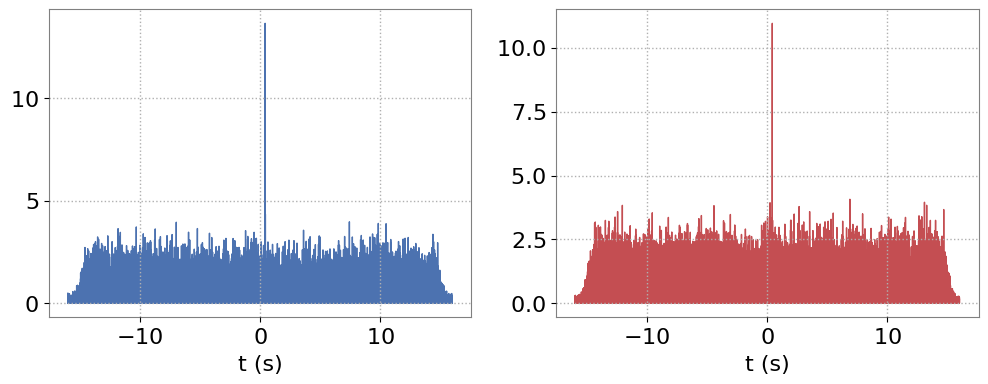

In [98]:
# NOTE: this shows \rho optimized over phase shift, for different times shifts

fig, axs = plt.subplots(1,2, figsize=[12,4])
axs[0].plot(times_d, np.abs(ifft_H1), c=colors[0])
axs[1].plot(times_d, np.abs(ifft_L1), c=colors[1])

for i in range(2):
    axs[i].set_xlabel(r't (s)')

Text(0.5, 0, 'rho')

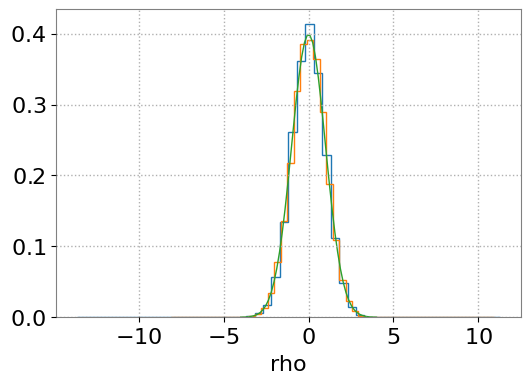

In [99]:
mask_test = (0. <= times_d) & (times_d <= 12.)

fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.hist(ifft_H1[mask_test], histtype='step', density=True);
ax.hist(ifft_L1[mask_test], histtype='step', density=True);
x_plt = np.linspace(-4., 4.)
ax.plot(x_plt, 1./np.sqrt(2*np.pi) * np.exp(-1./2 * x_plt**2))

ax.set_xlabel(r'rho')

In [100]:
alpha_td = np.arctan2(np.imag(ifft_H1_complex), np.real(ifft_H1_complex))
A_td = np.abs(ifft_H1_complex) / N_H1

rho = np.abs(ifft_H1_complex)
iopt = np.argmax(rho)
A_opt = A_td[iopt]
alpha_opt = alpha_td[iopt]
Deltat_opt = times_d[iopt]

In [101]:
A_opt, alpha_opt, Deltat_opt

(np.float64(0.16515820208170529),
 np.float64(1.810779332496994),
 np.float64(0.42529296875))

In [102]:
freq_fft = f_d
mask_ext = (5. < freq_fft) & (freq_fft < 1024.)
freq_ext = freq_fft[mask_ext]

def htemplate_wbp_td(A, Deltat, alpha):
    w_ifft = window_planck(freq_ext, 5., 1024., 5., 128.)
    h_fd = np.zeros_like(f_d, dtype=complex)
    h_fd[mask_ext] = w_ifft * A * np.exp(1j*alpha) * np.exp(-2*1j*np.pi*freq_fft[mask_ext]*Deltat) * template_fd[mask_ext]
    h_wbp_fd =  np.sqrt((2 * df) / psd_H1_interp(freq_fft)) * h_fd
    return ifft_positivef(freq_fft, h_wbp_fd, real=True, tstart=times_d[0])

In [103]:
_, ht_wbp_opt = htemplate_wbp_td(A_opt, Deltat_opt, alpha_opt)

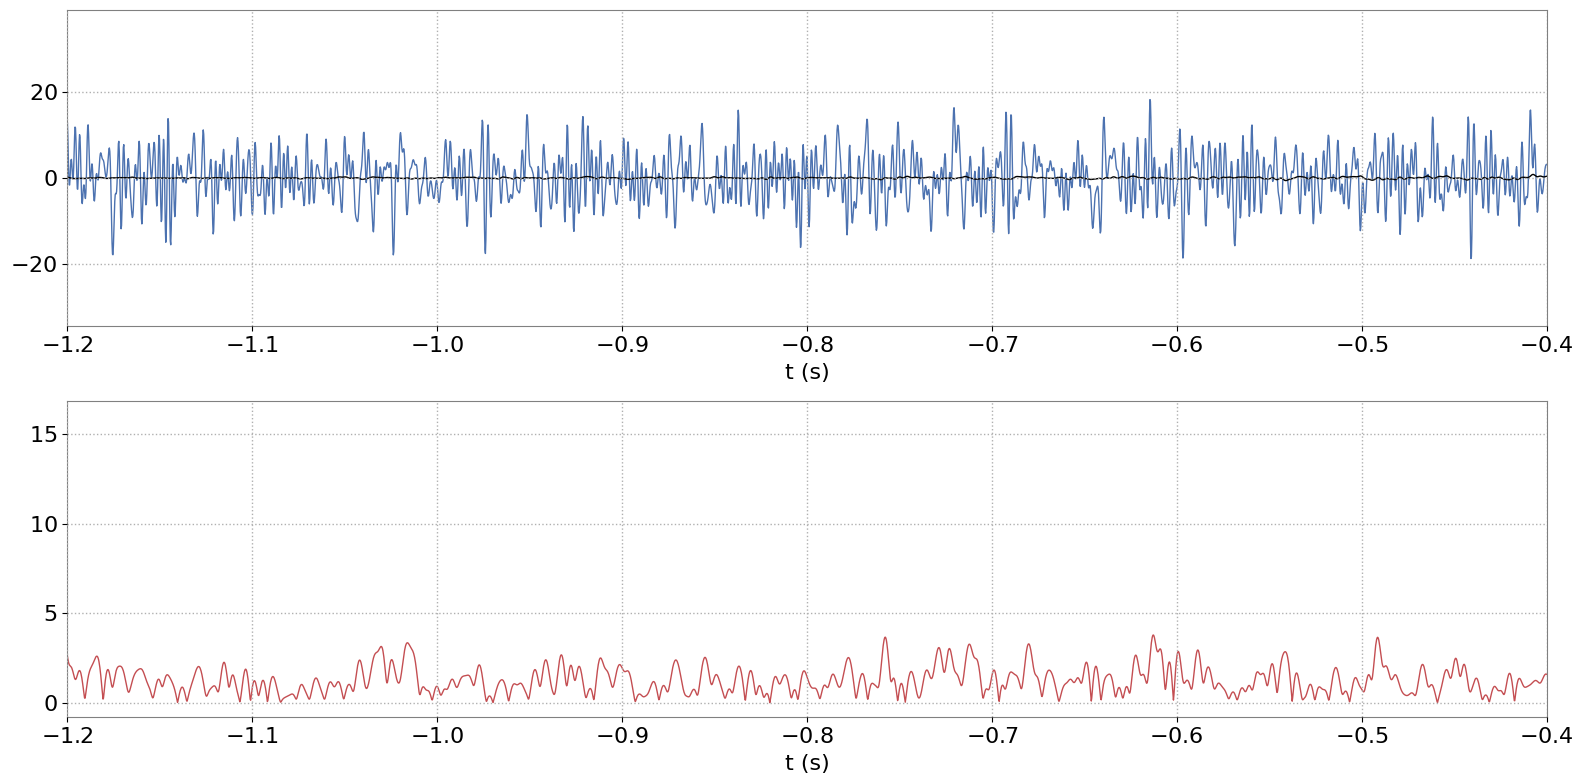

In [104]:
fig, axs = plt.subplots(2,1, figsize=[16,8])
axs[0].plot(times_d, strain_H1_td_wbp, c=colors[0])
axs[0].plot(times_d, ht_wbp_opt, c='k')
axs[1].plot(times_d, rho, c=colors[1])

for i in range(2):
    axs[i].set_xlim([-1.2, -0.4])
    axs[i].axvline(Deltat_opt, c='k', lw=1.)
    axs[i].set_xlabel(r't (s)')

fig.tight_layout()